## Imports

In [1]:
import sys 
import os
import numpy as np 
import matplotlib.pyplot as plt
from skimage import io
import math

import torch
import torchvision 
import torch.optim as optim
import torch.nn as nn
from torch.utils.data.dataset import Dataset
sys.path.insert(0, '../../Utils')

import models
from train import *
from metrics import * 
from Gradient_Ascent import data_extraction
from skimage.restoration import denoise_nl_means, estimate_sigma

print("Python: %s" % sys.version)
print("Pytorch: %s" % torch.__version__)

Python: 3.6.5 (default, Jun 21 2018, 23:07:39) 
[GCC 5.4.0 20160609]
Pytorch: 0.4.0


## Hyperparameters

In [2]:
n_epochs = 100
batch_size = 128
lr = 0.01

## Load CIFAR10

tensor([ 21,  11,  14,  36,   8,   4,  26,  13,  33,   7,  23,  38,
         25,   9,  23,  13,  23,  37,  36,  22,   9,  24,  32,   7,
         10,  36,  32,  33,  31,  16,   0,  39,  32,   4,  39,  14,
         26,  12,  25,  38,   7,  10,  35,   7,  38,  34,  16,   8,
         34,  14,   1,  38,  35,  36,  23,  13,  30,  32,  21,  25,
         35,   7,  27,   9,  31,  11,  10,   5,   7,  16,  10,  21,
         30,   1,   3,  28,  30,  19,  37,  25,   6,  24,  26,  31,
         32,  22,  33,   9,  17,  11,  23,  19,  18,  15,  31,  14,
         30,   5,  12,  31,  28,  11,  12,  36,   1,  20,   3,  30,
          1,   9,   0,  35,  35,  12,   6,   3,   6,  21,   5,  37,
         25,  36,   1,  35,  33,  29,  19,  22])
tensor(-1.)
tensor(0.9373)
torch.Size([128, 1, 112, 92])


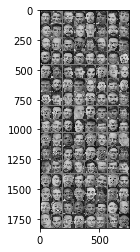

In [3]:
data_dir = "Data/"

img_paths = []
for p in os.listdir(data_dir): 
    for i in os.listdir(os.path.join(data_dir,p)): 
        img_paths.append(os.path.join(data_dir,p,i))
        
people = []
people_to_idx = {}
k = 0 
for i in img_paths: 
    name = i.split('/')[-2]
    if name not in people_to_idx: 
        people.append(name)
        people_to_idx[name] = k
        k += 1


img_paths = np.random.permutation(img_paths)

lfw_size = len(img_paths)

lfw_train_size = int(0.7 * lfw_size)

lfw_train_list = img_paths[:lfw_train_size]
lfw_test_list = img_paths[lfw_train_size:]

class LFWDataset(Dataset): 
    def __init__(self, file_list, class_to_label, transform=None): 
        self.file_list = file_list
        self.transform = transform
        
        self.people_to_idx = class_to_label
        
                
    def __len__(self): 
        return len(self.file_list)
    def __getitem__(self, idx): 
        
        image = np.empty((112, 92, 1), dtype=np.uint8)
        img_path = self.file_list[idx]
        im = io.imread(img_path)
        im = im.reshape(112,92)
        image[:,:,0]= im
#         image[:,:,1]= im
#         image[:,:,2]= im

        label = self.people_to_idx[img_path.split('/')[-2]]
        
        if self.transform is not None: 
            image = self.transform(image)
        
        return image, label
        

# Data augmentation 
train_transform = torchvision.transforms.Compose([
    #torchvision.transforms.RandomRotation(10),
    #torchvision.transforms.RandomHorizontalFlip(),
    #torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
 
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = torchvision.transforms.Compose([
    #torchvision.transforms.Pad(2),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#     torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
    

trainset = LFWDataset(lfw_train_list, people_to_idx, transform=train_transform)
testset = LFWDataset(lfw_test_list, people_to_idx, transform=test_transform)
sampleset = LFWDataset(lfw_test_list, people_to_idx, transform=torchvision.transforms.ToTensor())

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)
sampleloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False, num_workers=2)
sampleloader2 = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)

# helper function to unnormalize and plot image 
def imshow(img):
    img = np.array(img)
    img = img / 2 + 0.5
    img = np.moveaxis(img, 0, -1)
    plt.imshow(img)
    
# display sample from dataset 
imgs,labels = iter(trainloader).next()
imshow(torchvision.utils.make_grid(imgs)) 
print(labels)
print(imgs.min())
print(imgs.max())
print(imgs.shape)

## Model Architecture

In [184]:
class mlp(nn.Module): 
    def __init__(self, n_in=112*92, n_out=40, n_hidden=3000): 
        super(mlp, self).__init__()
        
        self.hidden1 = nn.Linear(n_in, n_out)        
#         self.act = nn.Sigmoid()
#         self.soft = nn.Softmax()
        
#         self.hidden2 = nn.Linear(n_hidden, n_out)
#         self.out_act = nn.Softmax(dim = 1)
    def forward(self, x):
#         x=x.reshape(32*32)
#         return input.view(input.size(0), -1)
        x = x.view(-1,112*92)
        out = self.hidden1(x)
#         print(x.size())
#         x = self.act(x)
#         out = self.soft(x)
#         x = self.hidden2(x)        
#         out = self.out_act(x)
        
        return out

In [185]:
# determine device to run network on (runs on gpu if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = mlp().to(device)

net.apply(models.weights_init)

net2 = mlp().to(device)
net2.apply(models.weights_init)

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=lr)
optimizer2 = optim.SGD(net2.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

## Training 

[0/100]

Total accuracy = 50.83 %


Train Accuracy 19.285714


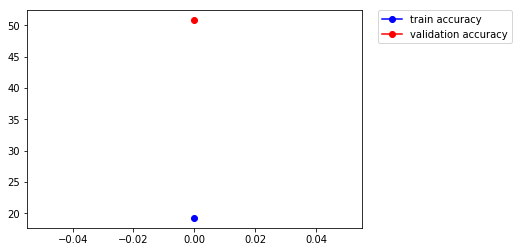

[1/100]

Total accuracy = 62.50 %


Train Accuracy 62.142857


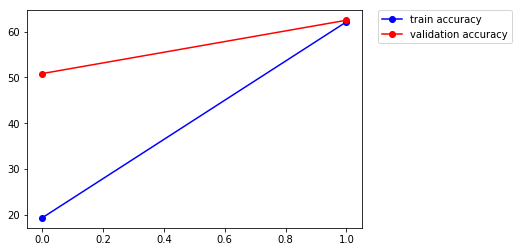

[2/100]

Total accuracy = 70.00 %


Train Accuracy 75.000000


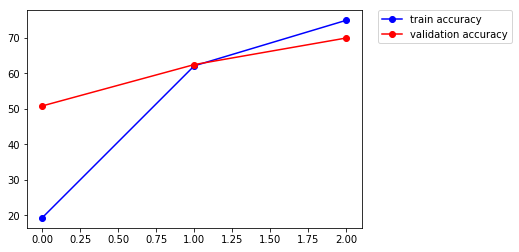

[3/100]

Total accuracy = 77.50 %


Train Accuracy 84.285714


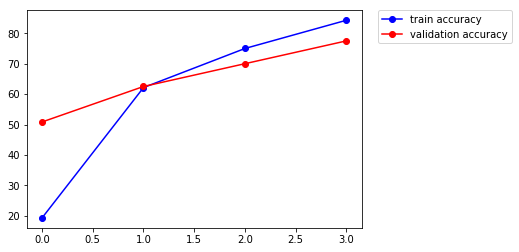

[4/100]

Total accuracy = 81.67 %


Train Accuracy 94.285714


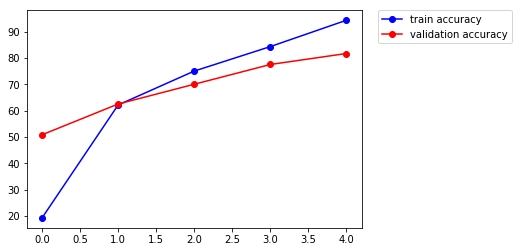

[5/100]

Total accuracy = 78.33 %


Train Accuracy 93.571429


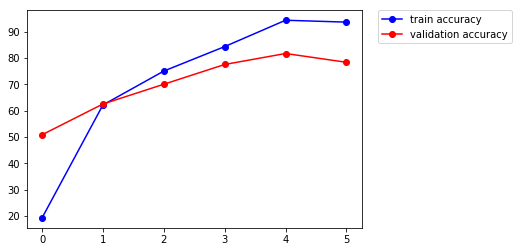

[6/100]

Total accuracy = 80.00 %


Train Accuracy 96.785714


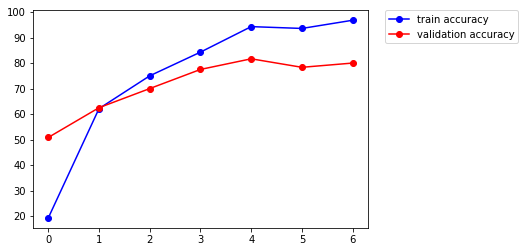

[7/100]

Total accuracy = 78.33 %


Train Accuracy 97.142857


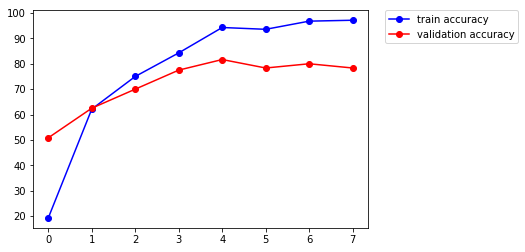

[8/100]

Total accuracy = 80.00 %


Train Accuracy 98.214286


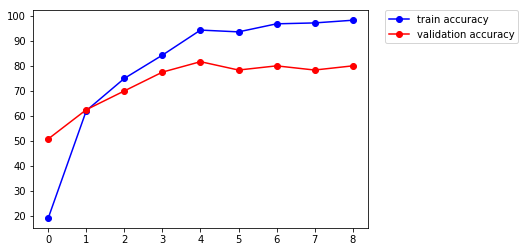

[9/100]

Total accuracy = 79.17 %


Train Accuracy 98.214286


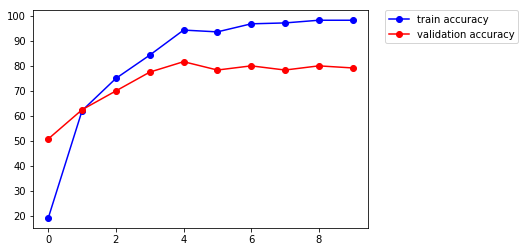

[10/100]

Total accuracy = 84.17 %


Train Accuracy 99.285714


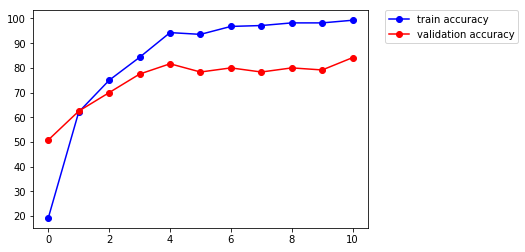

[11/100]

Total accuracy = 83.33 %


Train Accuracy 98.571429


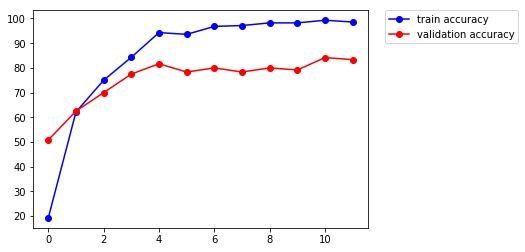

[12/100]

Total accuracy = 82.50 %


Train Accuracy 99.642857


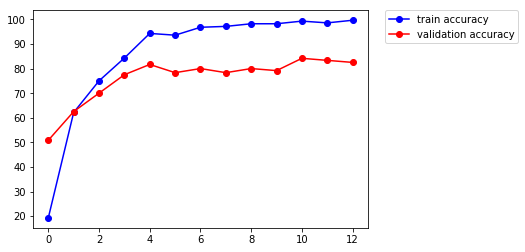

[13/100]

Total accuracy = 82.50 %


Train Accuracy 100.000000


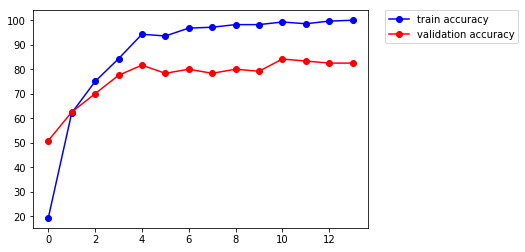

[14/100]

Total accuracy = 83.33 %


Train Accuracy 100.000000


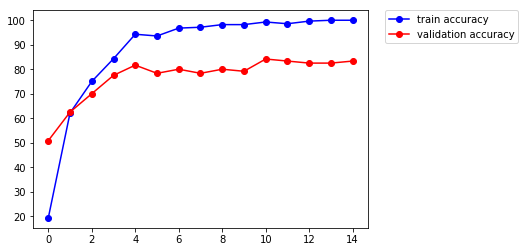

[15/100]

Total accuracy = 83.33 %


Train Accuracy 100.000000


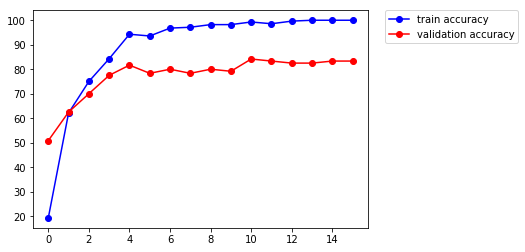

[16/100]

Total accuracy = 83.33 %


Train Accuracy 100.000000


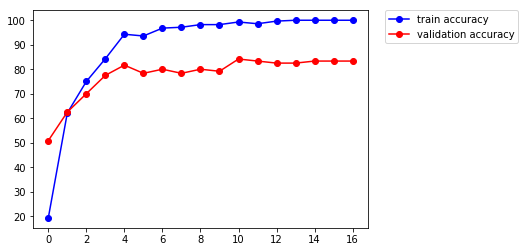

[17/100]

Total accuracy = 82.50 %


Train Accuracy 100.000000


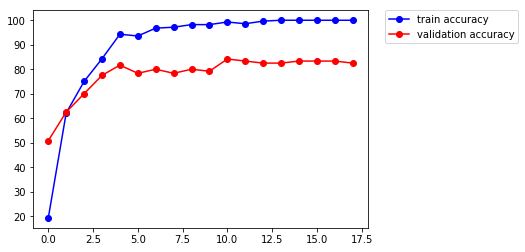

[18/100]

Total accuracy = 82.50 %


Train Accuracy 100.000000


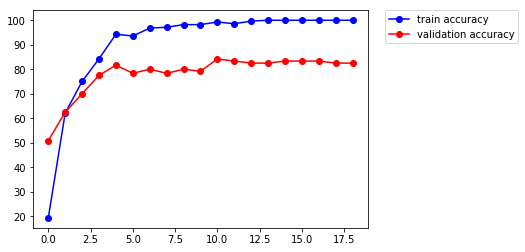

[19/100]

Total accuracy = 81.67 %


Train Accuracy 100.000000


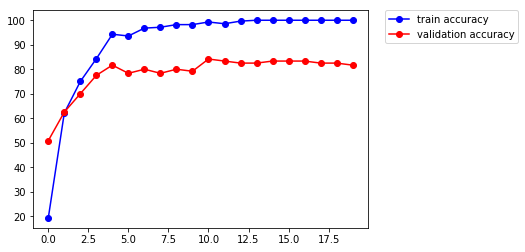

[20/100]

Total accuracy = 82.50 %


Train Accuracy 100.000000


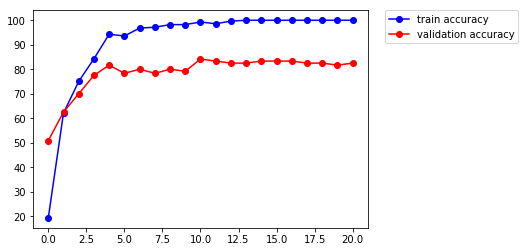

[21/100]

Total accuracy = 82.50 %


Train Accuracy 100.000000


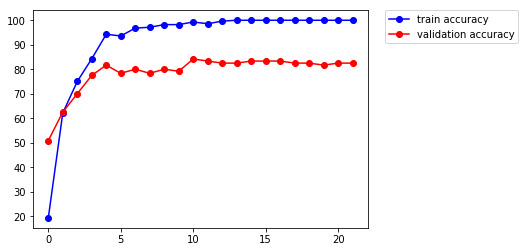

[22/100]

Total accuracy = 82.50 %


Train Accuracy 100.000000


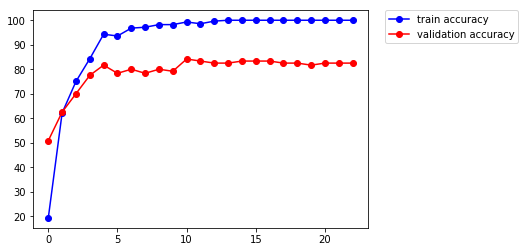

[23/100]

Total accuracy = 82.50 %


Train Accuracy 100.000000


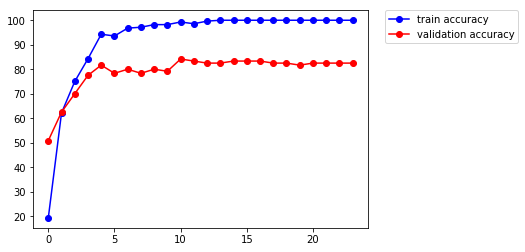

[24/100]

Total accuracy = 82.50 %


Train Accuracy 100.000000


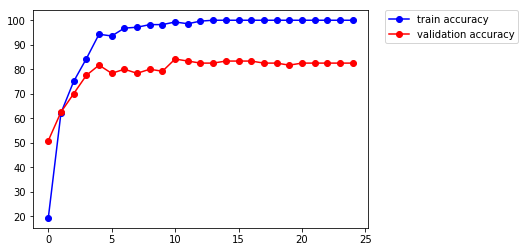

[25/100]

Total accuracy = 82.50 %


Train Accuracy 100.000000


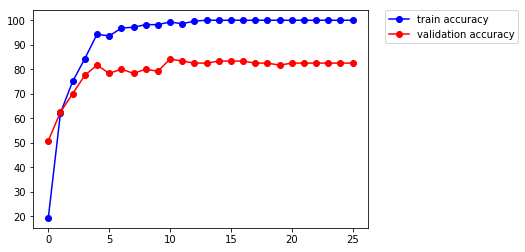

[26/100]

Total accuracy = 82.50 %


Train Accuracy 100.000000


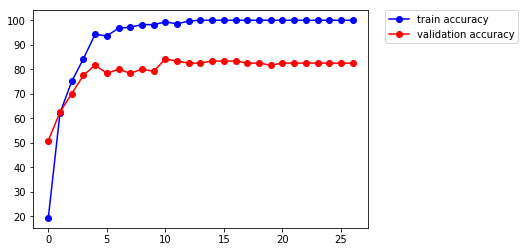

[27/100]

Total accuracy = 82.50 %


Train Accuracy 100.000000


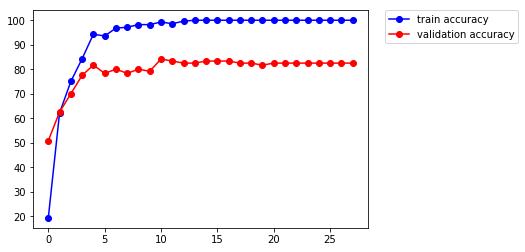

[28/100]

Total accuracy = 83.33 %


Train Accuracy 100.000000


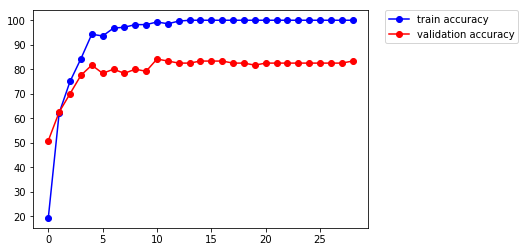

[29/100]

Total accuracy = 83.33 %


Train Accuracy 100.000000


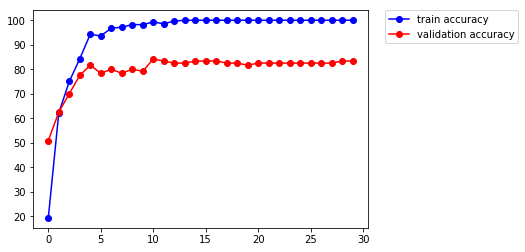

[30/100]

Total accuracy = 83.33 %


Train Accuracy 100.000000


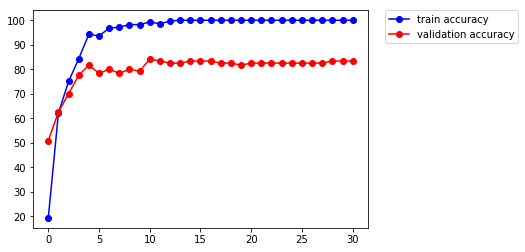

[31/100]

Total accuracy = 83.33 %


Train Accuracy 100.000000


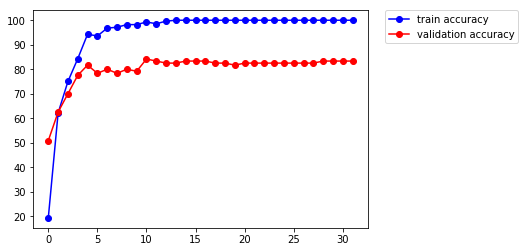

[32/100]

Total accuracy = 83.33 %


Train Accuracy 100.000000


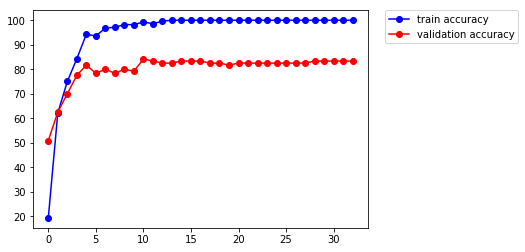

[33/100]

Total accuracy = 83.33 %


Train Accuracy 100.000000


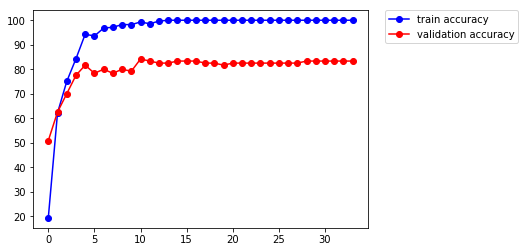

[34/100]

Total accuracy = 84.17 %


Train Accuracy 100.000000


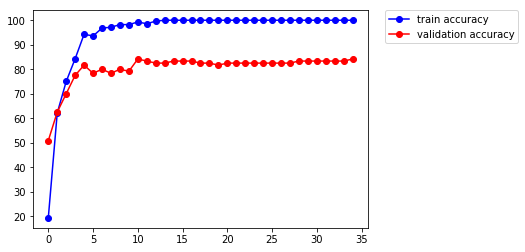

[35/100]

Total accuracy = 84.17 %


Train Accuracy 100.000000


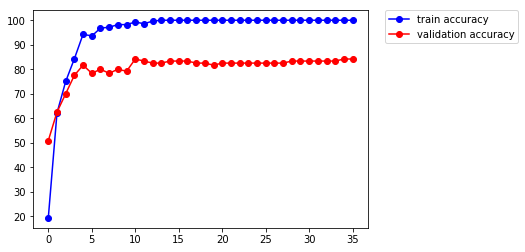

[36/100]

Total accuracy = 84.17 %


Train Accuracy 100.000000


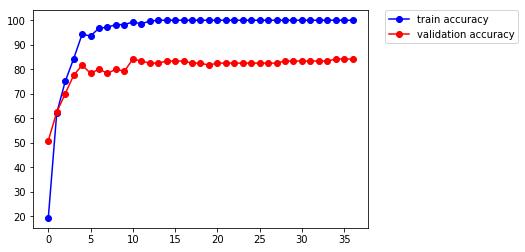

[37/100]

Total accuracy = 84.17 %


Train Accuracy 100.000000


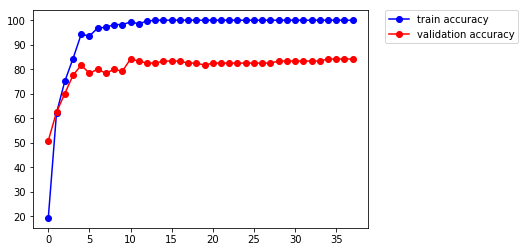

[38/100]

Total accuracy = 84.17 %


Train Accuracy 100.000000


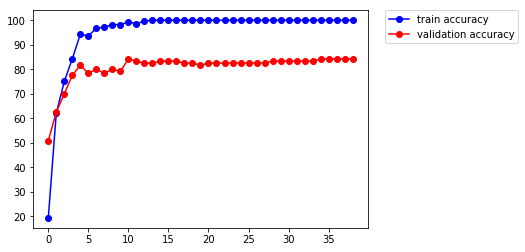

[39/100]

Total accuracy = 84.17 %


Train Accuracy 100.000000


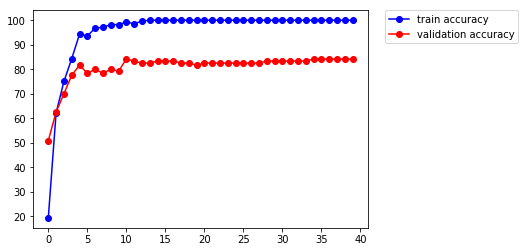

[40/100]

Total accuracy = 84.17 %


Train Accuracy 100.000000


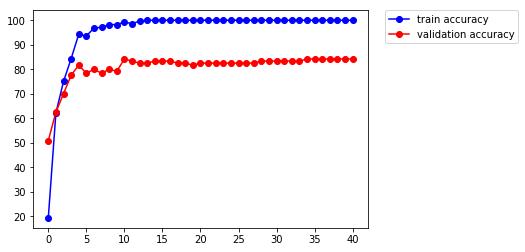

[41/100]

Total accuracy = 84.17 %


Train Accuracy 100.000000


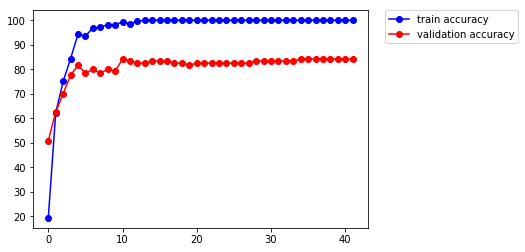

[42/100]

Total accuracy = 84.17 %


Train Accuracy 100.000000


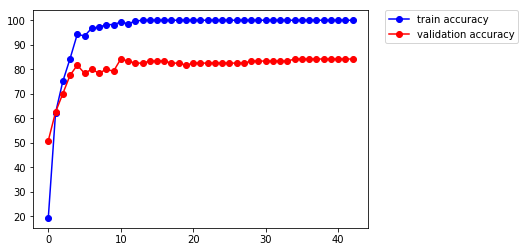

[43/100]

Total accuracy = 84.17 %


Train Accuracy 100.000000


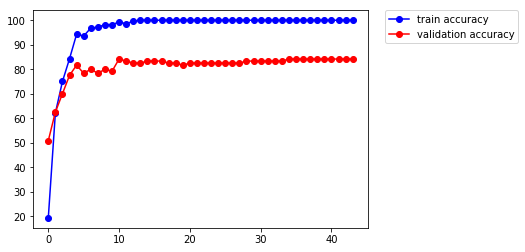

[44/100]

Total accuracy = 84.17 %


Train Accuracy 100.000000


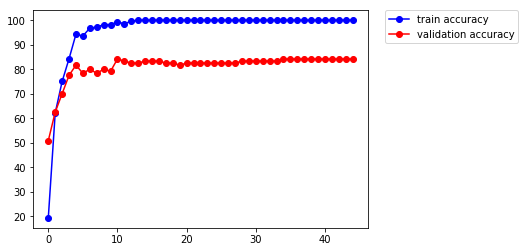

[45/100]

Total accuracy = 84.17 %


Train Accuracy 100.000000


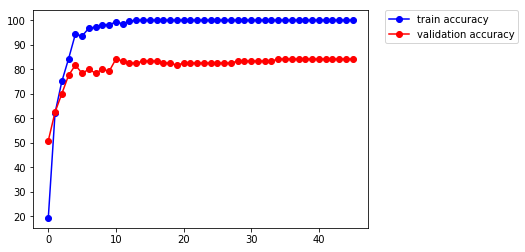

[46/100]

Total accuracy = 84.17 %


Train Accuracy 100.000000


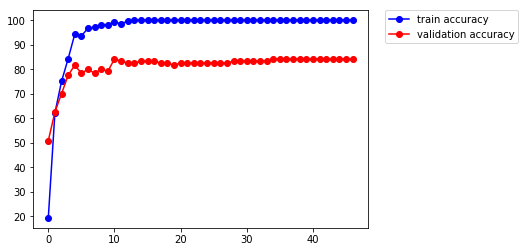

[47/100]

Total accuracy = 84.17 %


Train Accuracy 100.000000


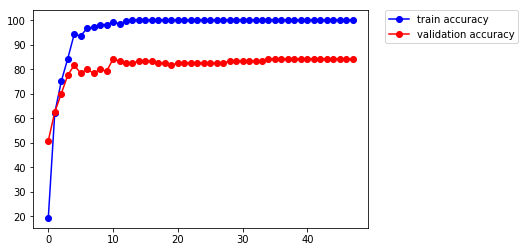

[48/100]

Total accuracy = 84.17 %


Train Accuracy 100.000000


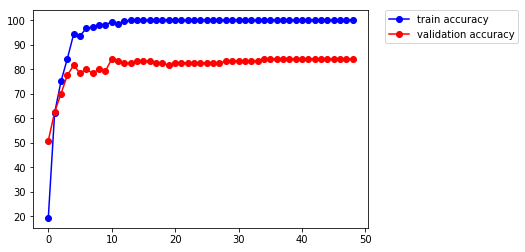

[49/100]

Total accuracy = 84.17 %


Train Accuracy 100.000000


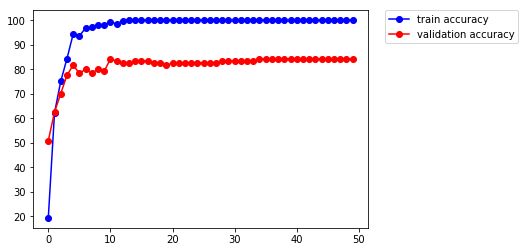

[50/100]

Total accuracy = 84.17 %


Train Accuracy 100.000000


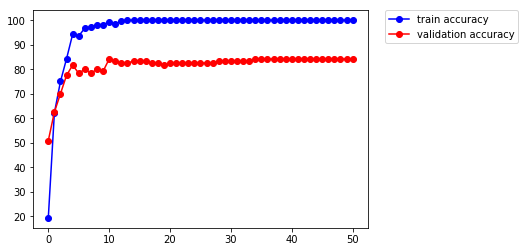

[51/100]

Total accuracy = 84.17 %


Train Accuracy 100.000000


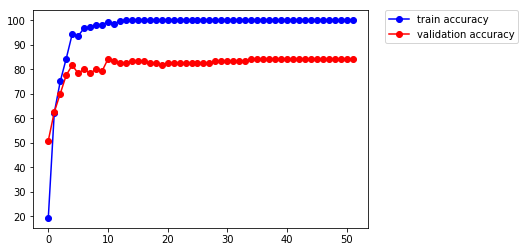

[52/100]

Total accuracy = 84.17 %


Train Accuracy 100.000000


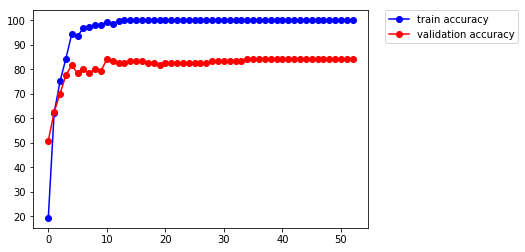

[53/100]

Total accuracy = 84.17 %


Train Accuracy 100.000000


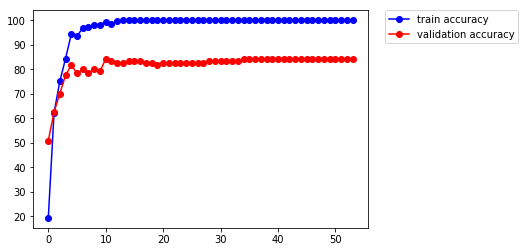

[54/100]

Total accuracy = 84.17 %


Train Accuracy 100.000000


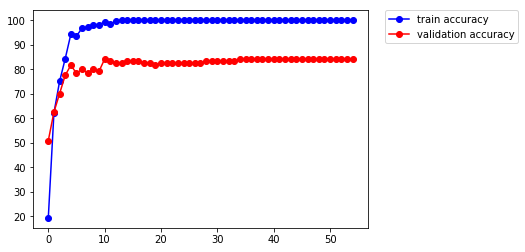

[55/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


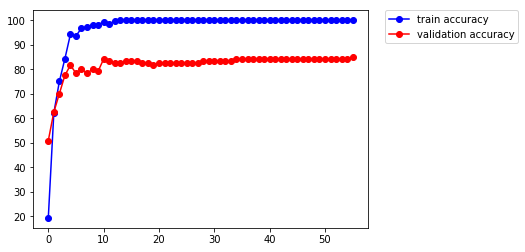

[56/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


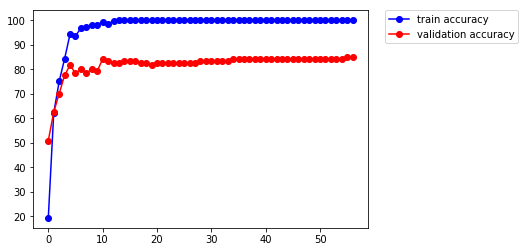

[57/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


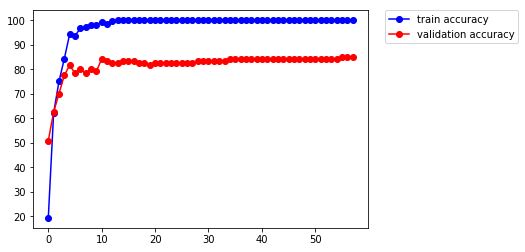

[58/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


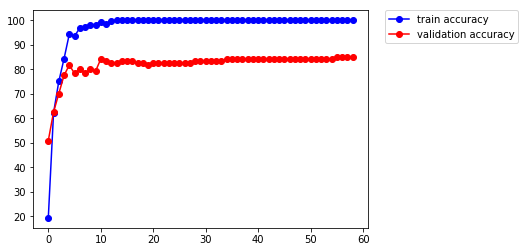

[59/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


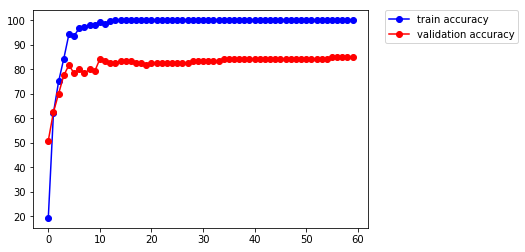

[60/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


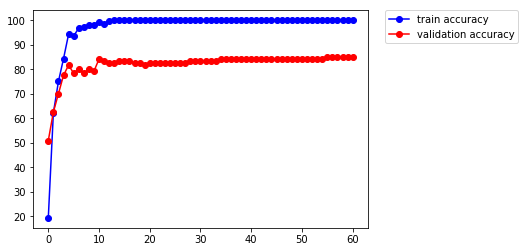

[61/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


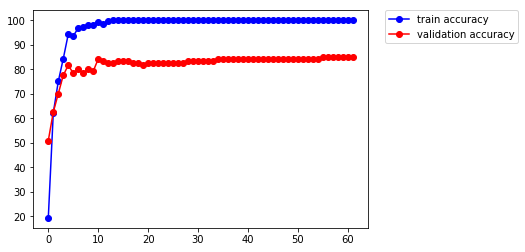

[62/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


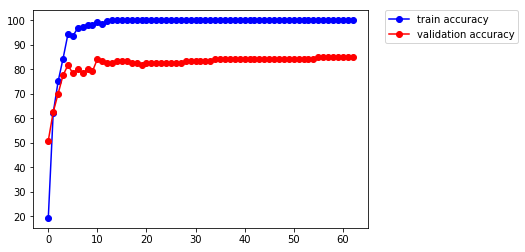

[63/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


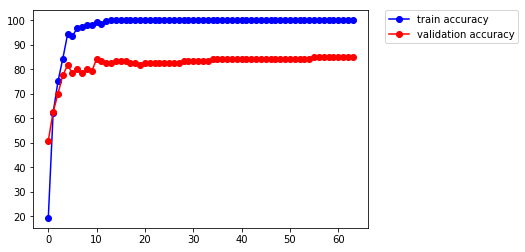

[64/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


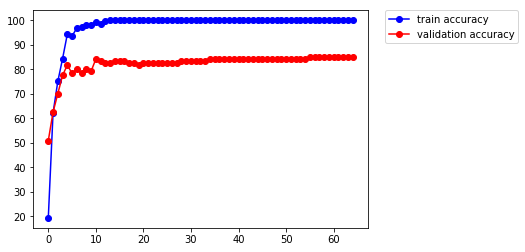

[65/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


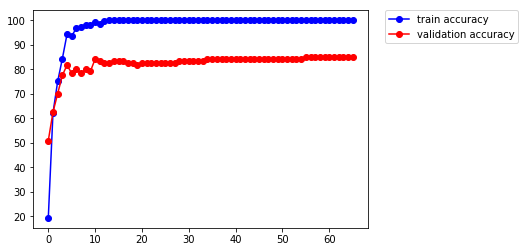

[66/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


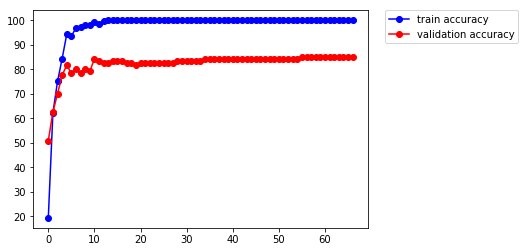

[67/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


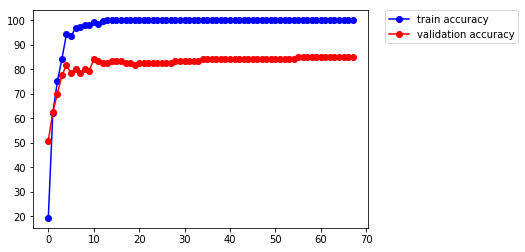

[68/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


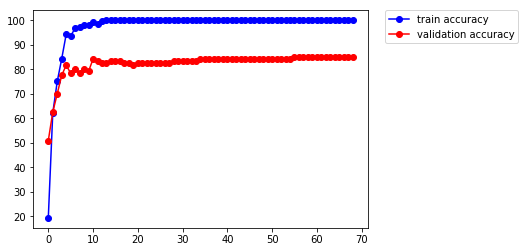

[69/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


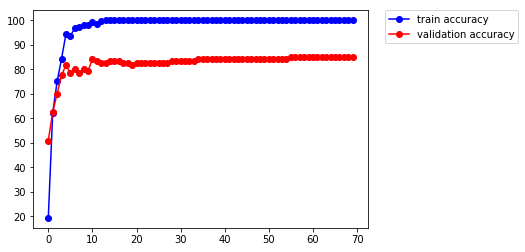

[70/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


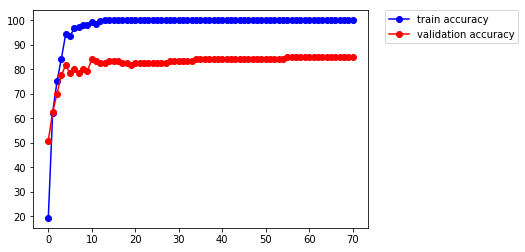

[71/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


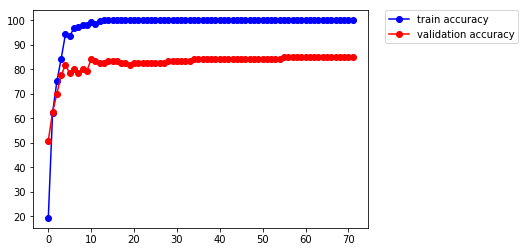

[72/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


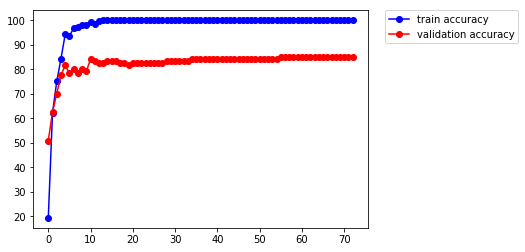

[73/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


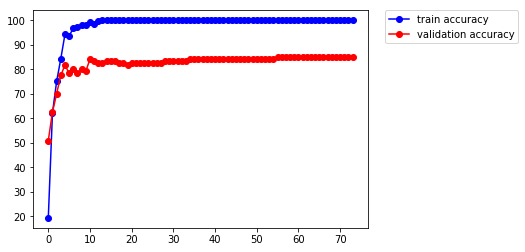

[74/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


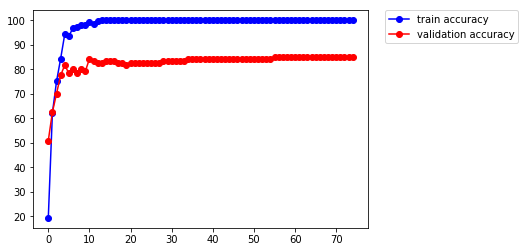

[75/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


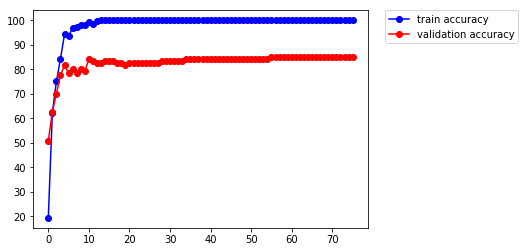

[76/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


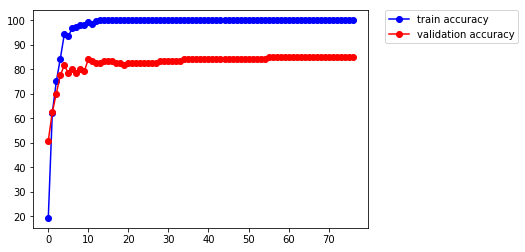

[77/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


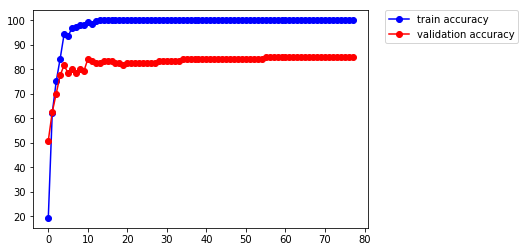

[78/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


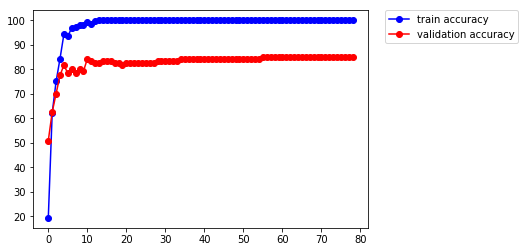

[79/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


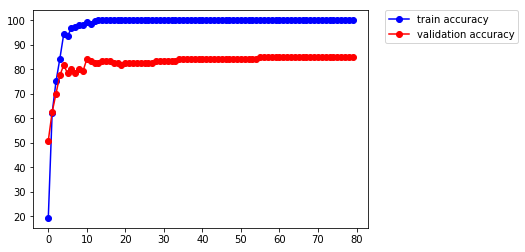

[80/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


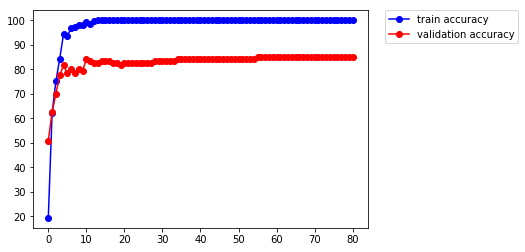

[81/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


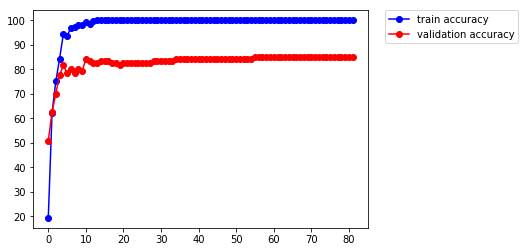

[82/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


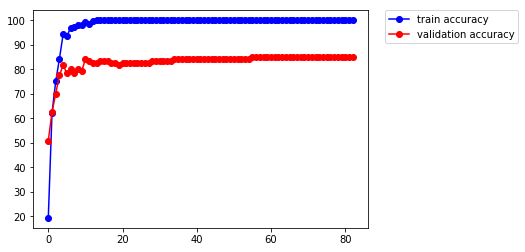

[83/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


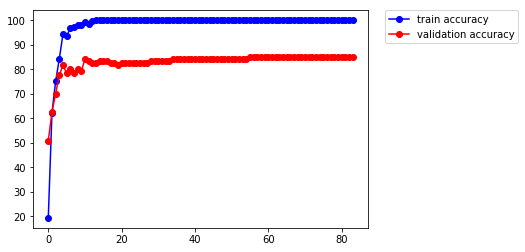

[84/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


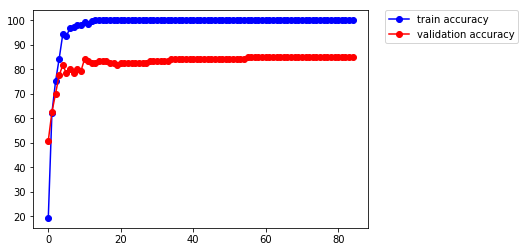

[85/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


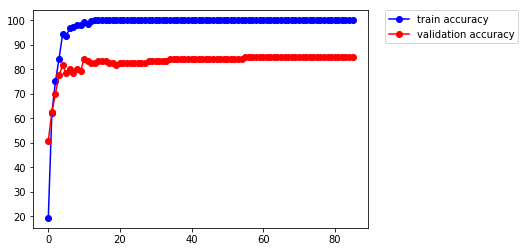

[86/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


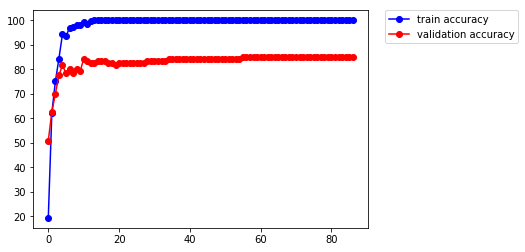

[87/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


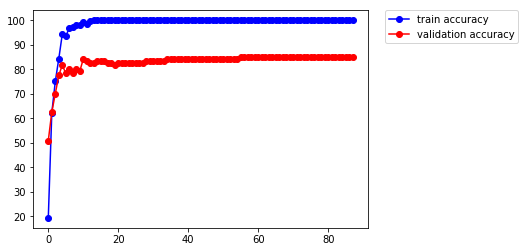

[88/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


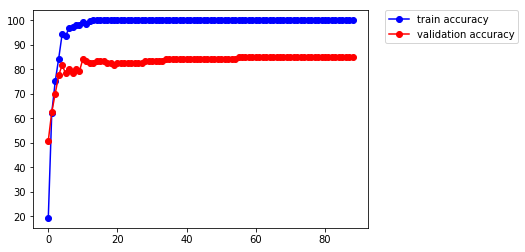

[89/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


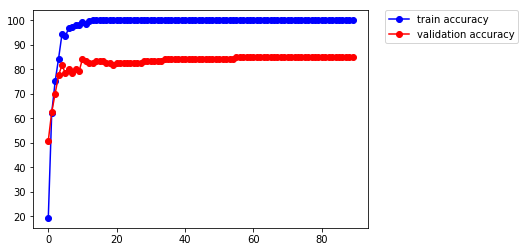

[90/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


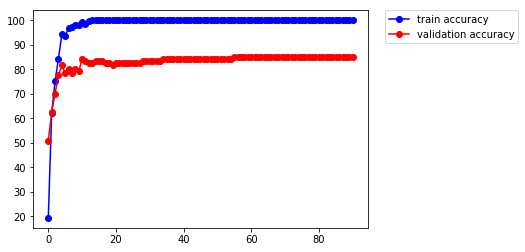

[91/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


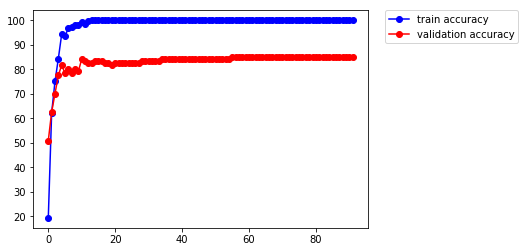

[92/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


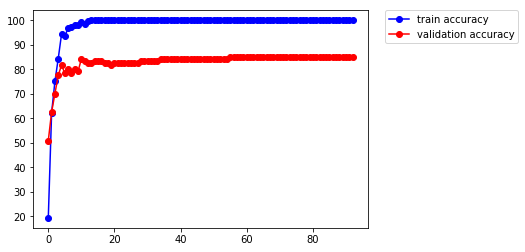

[93/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


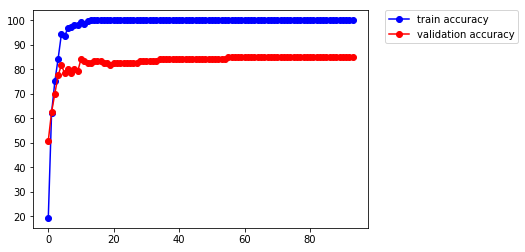

[94/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


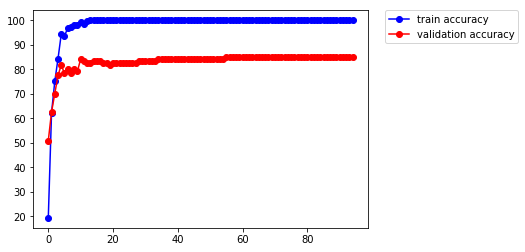

[95/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


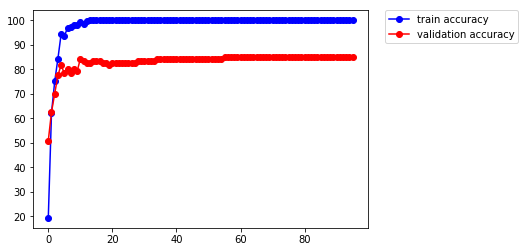

[96/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


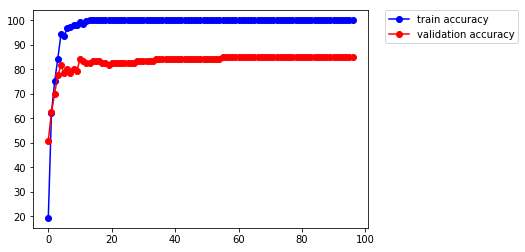

[97/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


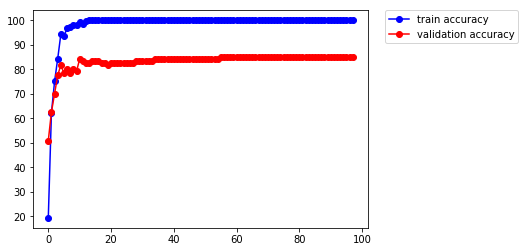

[98/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


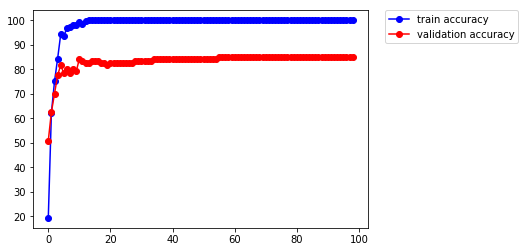

[99/100]

Total accuracy = 85.00 %


Train Accuracy 100.000000


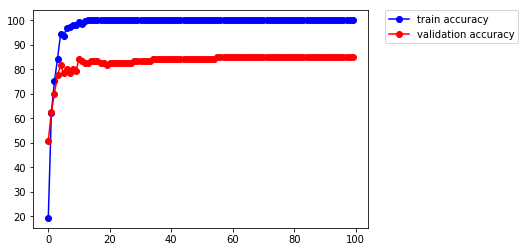

In [186]:
train(net, trainloader, testloader, optimizer, criterion, n_epochs, verbose=False)

[0/100]

Total accuracy = 15.00 %


Train Accuracy 4.285714


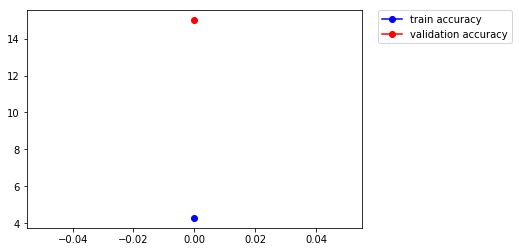

[1/100]

Total accuracy = 39.17 %


Train Accuracy 23.571429


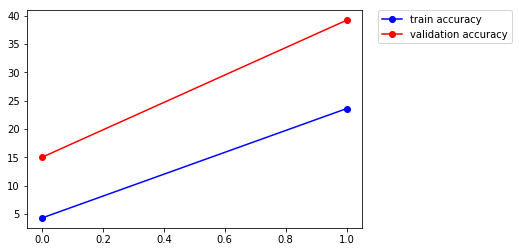

[2/100]

Total accuracy = 51.67 %


Train Accuracy 60.357143


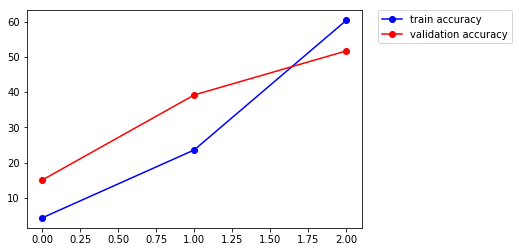

[3/100]

Total accuracy = 68.33 %


Train Accuracy 79.642857


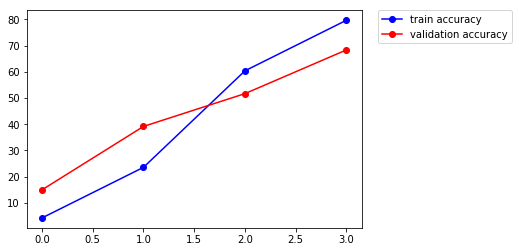

[4/100]

Total accuracy = 86.67 %


Train Accuracy 93.214286


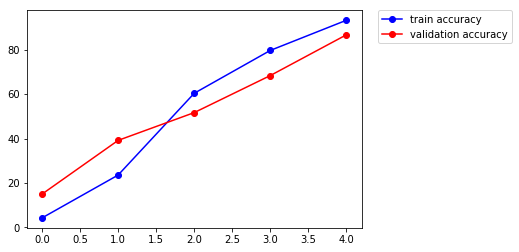

[5/100]

Total accuracy = 84.17 %


Train Accuracy 96.071429


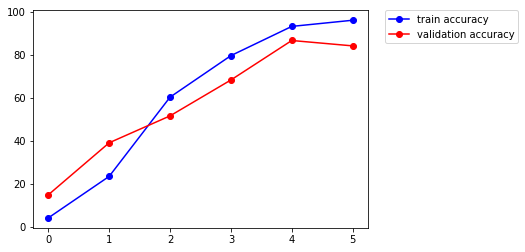

[6/100]

Total accuracy = 85.83 %


Train Accuracy 98.571429


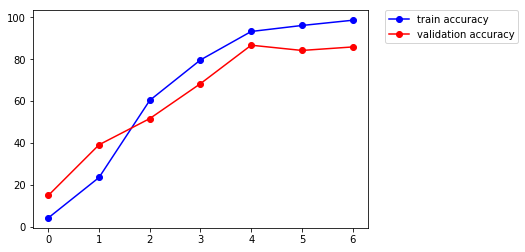

[7/100]

Total accuracy = 90.00 %


Train Accuracy 98.928571


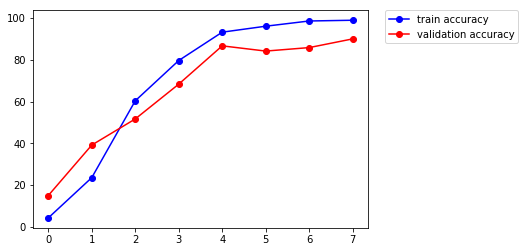

[8/100]

Total accuracy = 93.33 %


Train Accuracy 99.285714


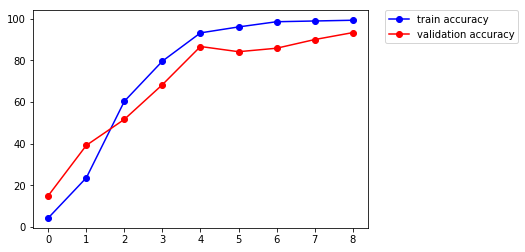

[9/100]

Total accuracy = 94.17 %


Train Accuracy 100.000000


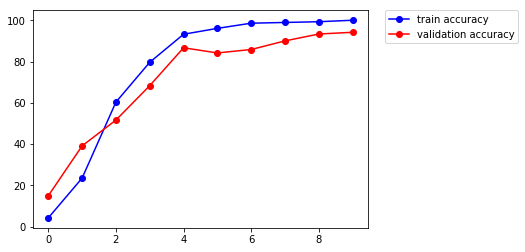

[10/100]

Total accuracy = 92.50 %


Train Accuracy 100.000000


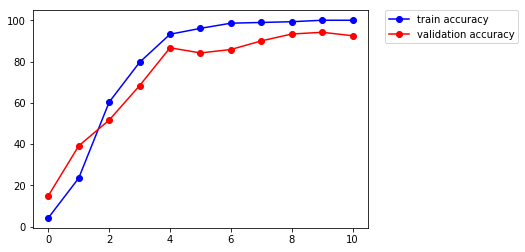

[11/100]

Total accuracy = 93.33 %


Train Accuracy 100.000000


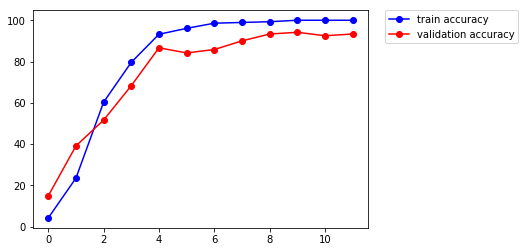

[12/100]

Total accuracy = 95.00 %


Train Accuracy 100.000000


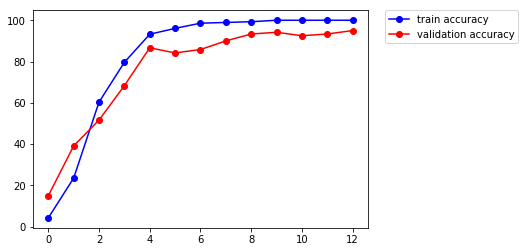

[13/100]

Total accuracy = 94.17 %


Train Accuracy 100.000000


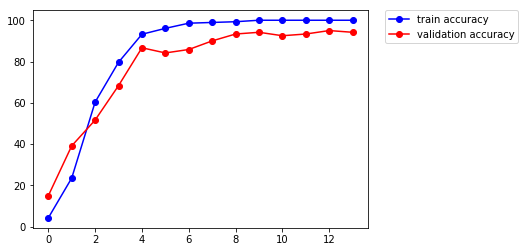

[14/100]

Total accuracy = 95.00 %


Train Accuracy 100.000000


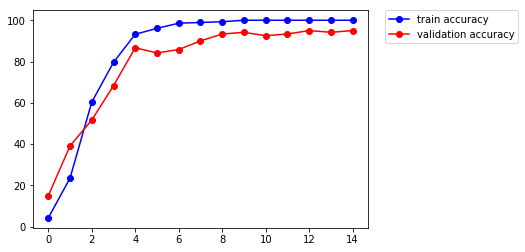

[15/100]

Total accuracy = 95.00 %


Train Accuracy 100.000000


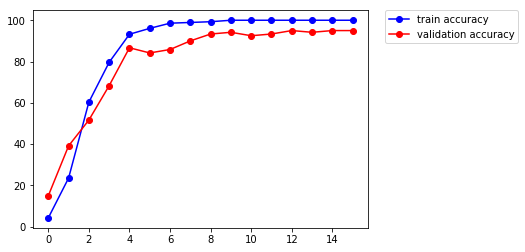

[16/100]

Total accuracy = 95.00 %


Train Accuracy 100.000000


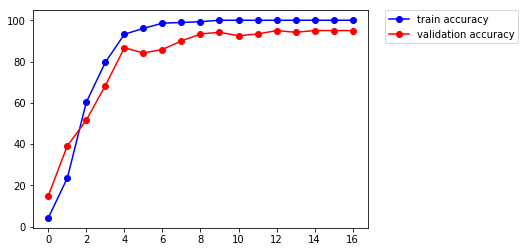

[17/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


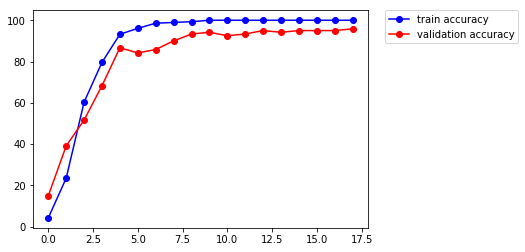

[18/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


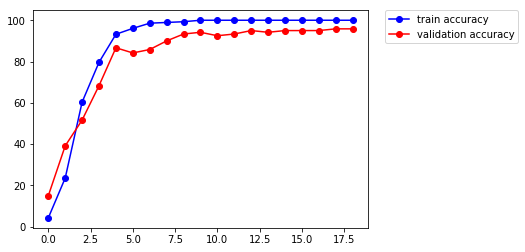

[19/100]

Total accuracy = 95.00 %


Train Accuracy 100.000000


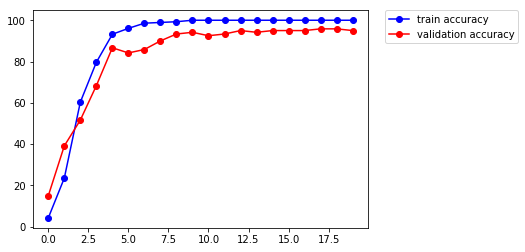

[20/100]

Total accuracy = 95.00 %


Train Accuracy 100.000000


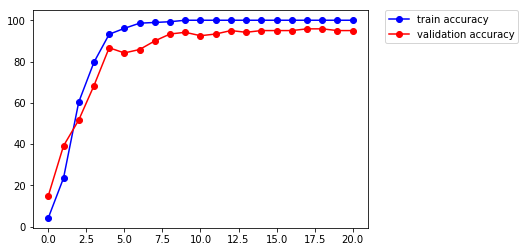

[21/100]

Total accuracy = 95.00 %


Train Accuracy 100.000000


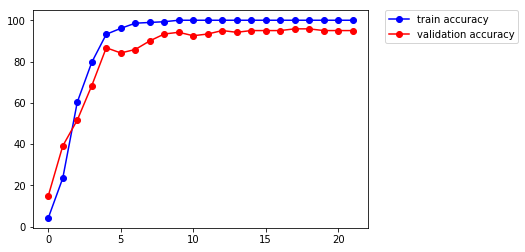

[22/100]

Total accuracy = 95.00 %


Train Accuracy 100.000000


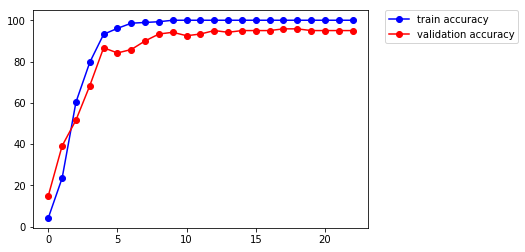

[23/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


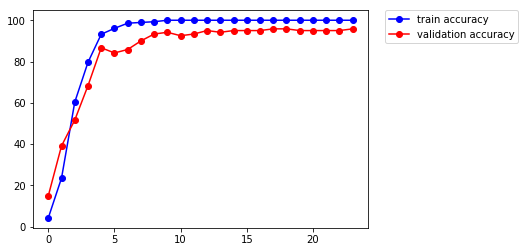

[24/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


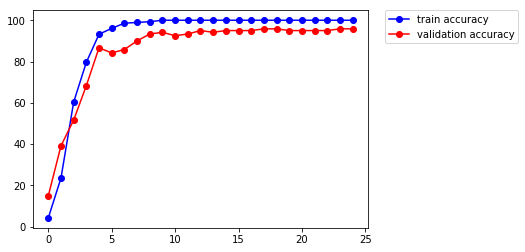

[25/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


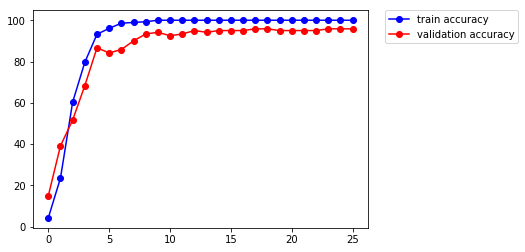

[26/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


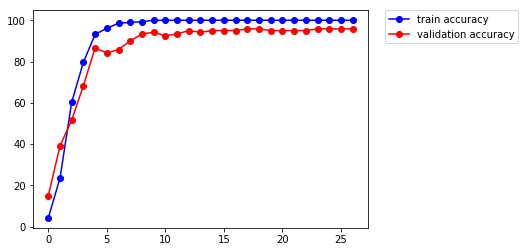

[27/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


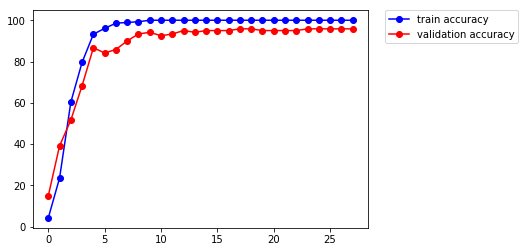

[28/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


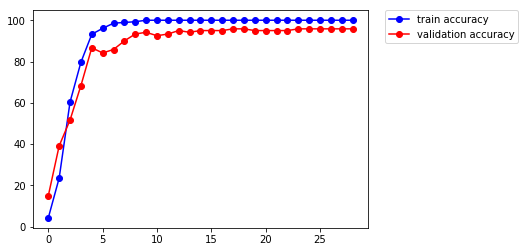

[29/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


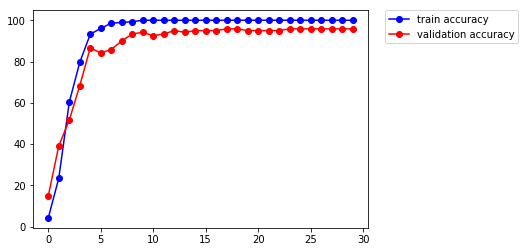

[30/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


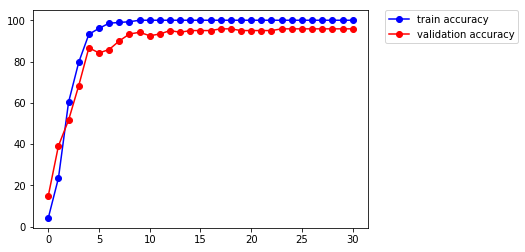

[31/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


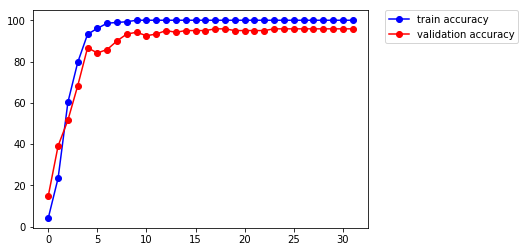

[32/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


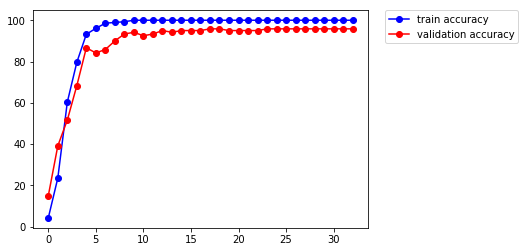

[33/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


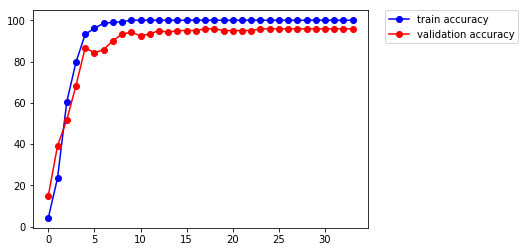

[34/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


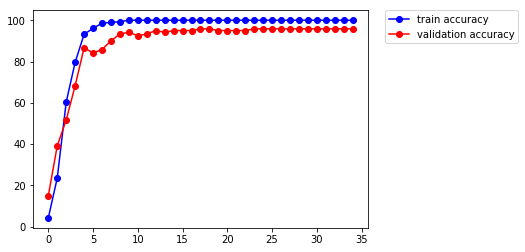

[35/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


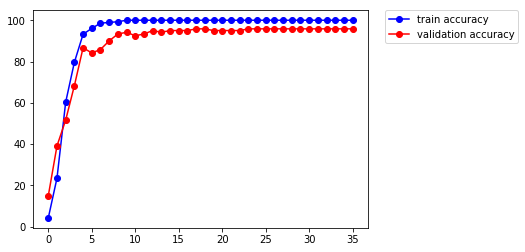

[36/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


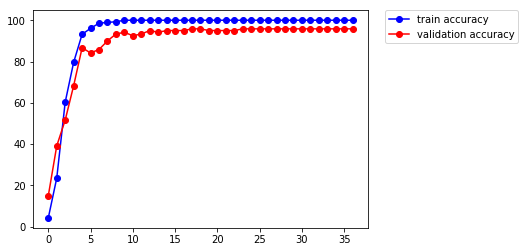

[37/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


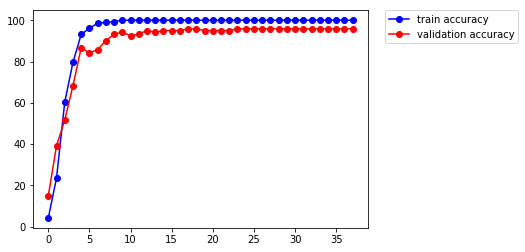

[38/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


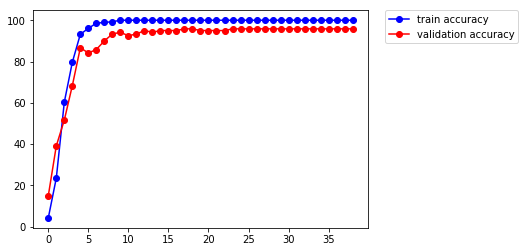

[39/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


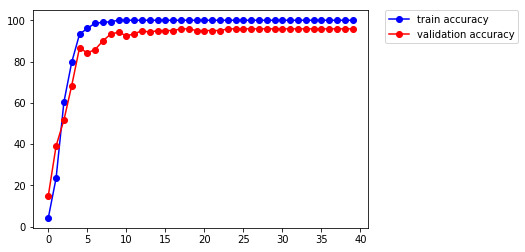

[40/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


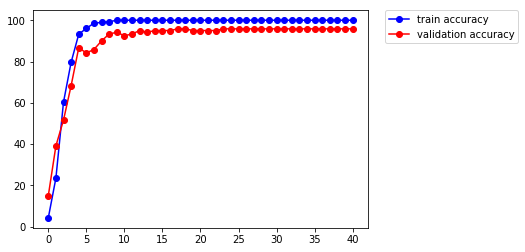

[41/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


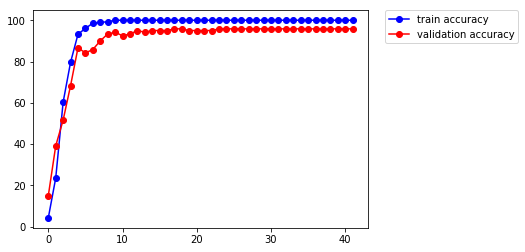

[42/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


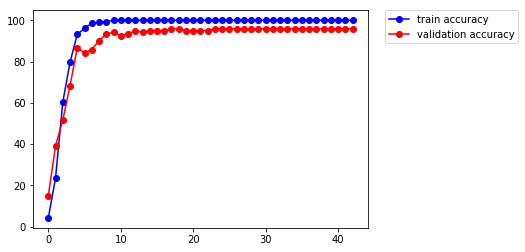

[43/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


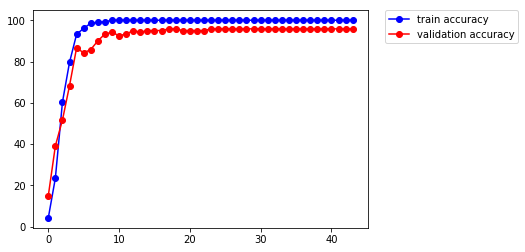

[44/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


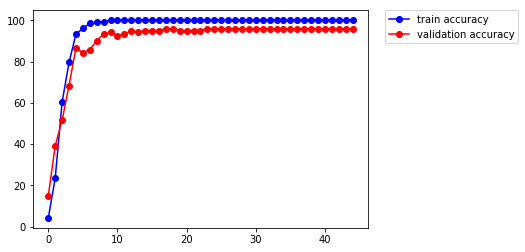

[45/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


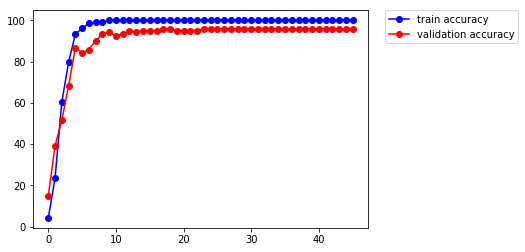

[46/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


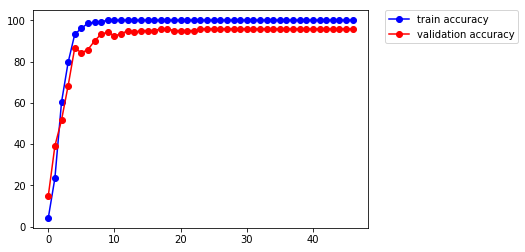

[47/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


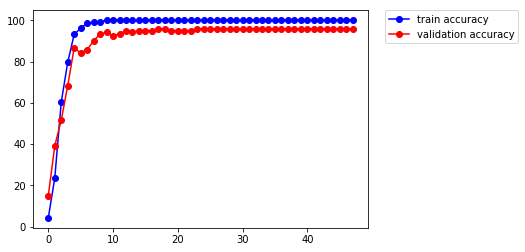

[48/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


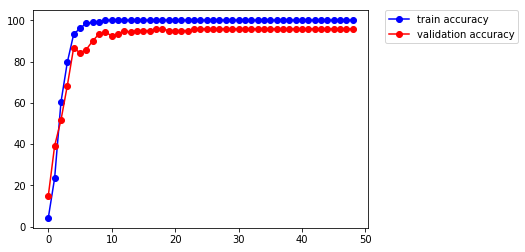

[49/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


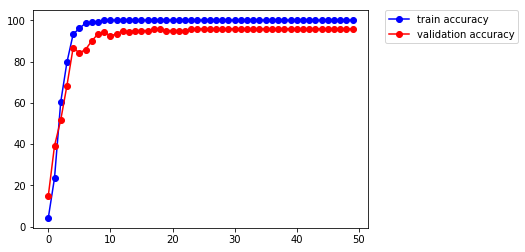

[50/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


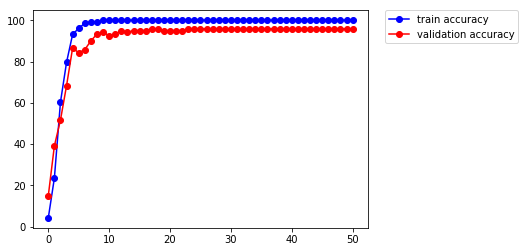

[51/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


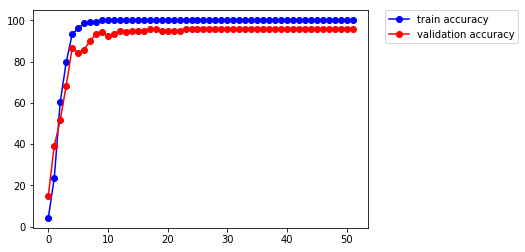

[52/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


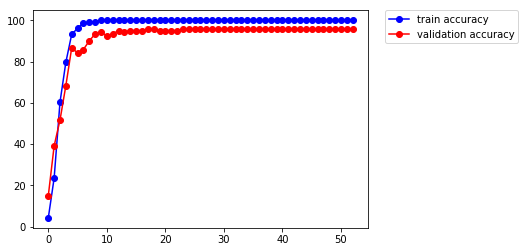

[53/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


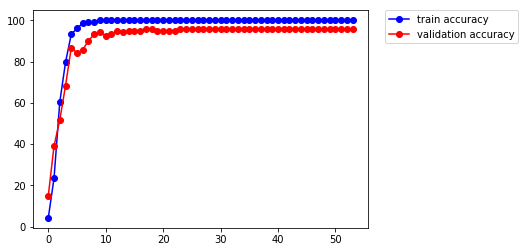

[54/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


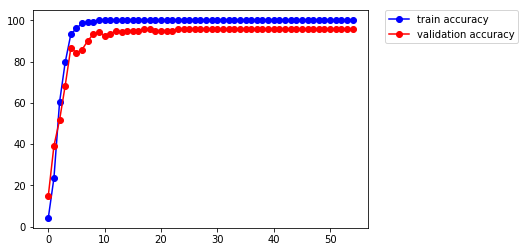

[55/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


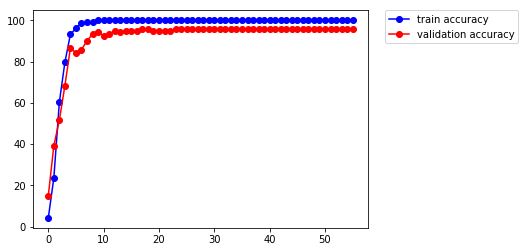

[56/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


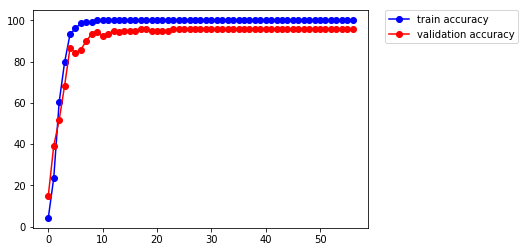

[57/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


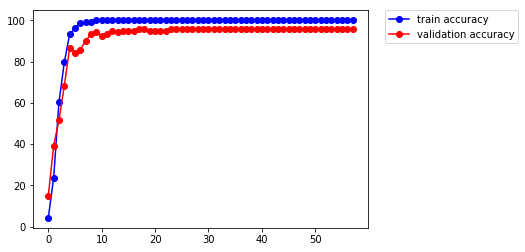

[58/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


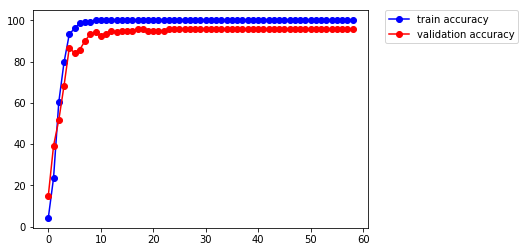

[59/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


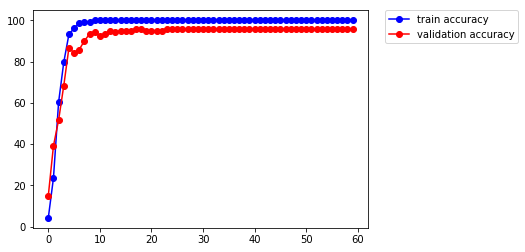

[60/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


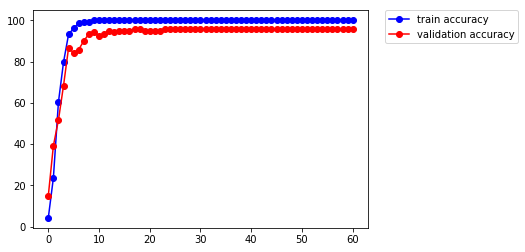

[61/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


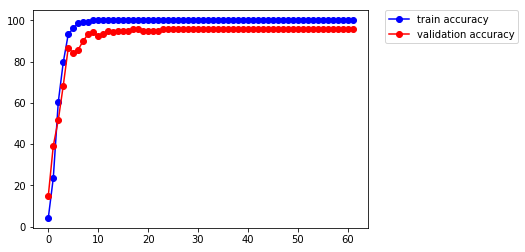

[62/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


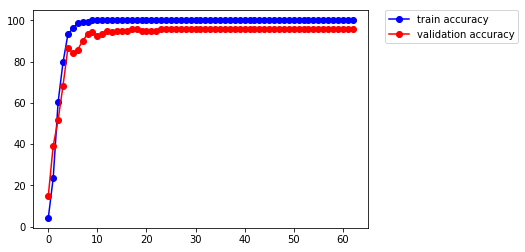

[63/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


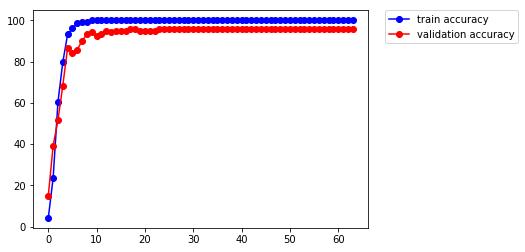

[64/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


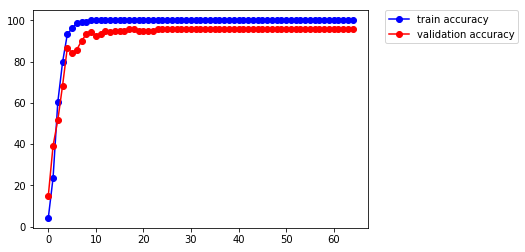

[65/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


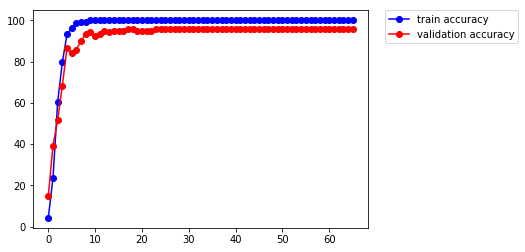

[66/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


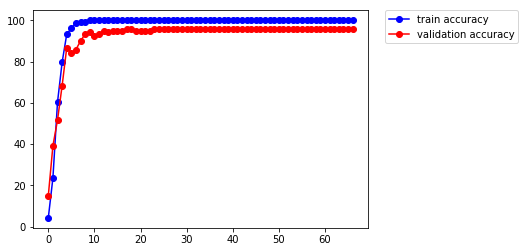

[67/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


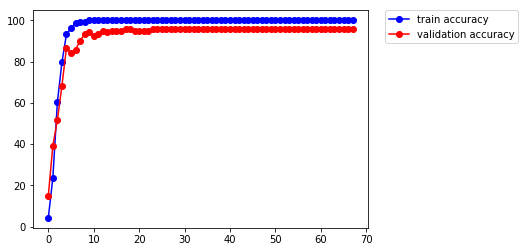

[68/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


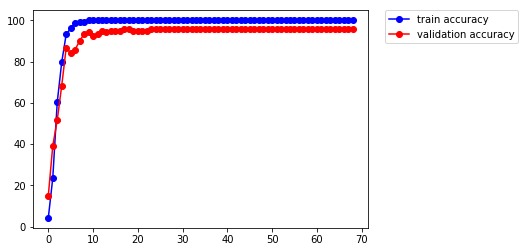

[69/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


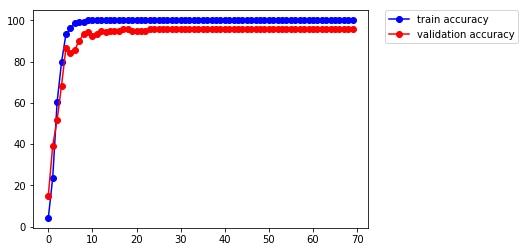

[70/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


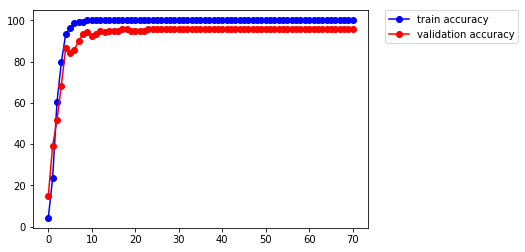

[71/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


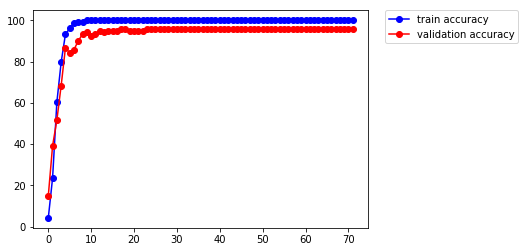

[72/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


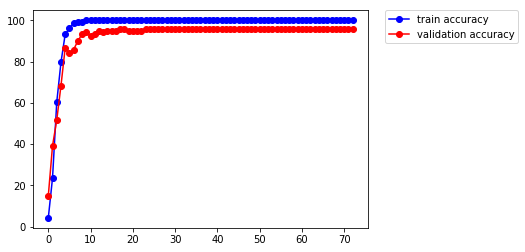

[73/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


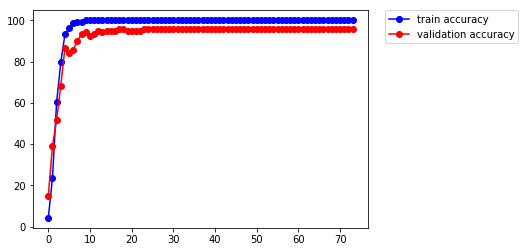

[74/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


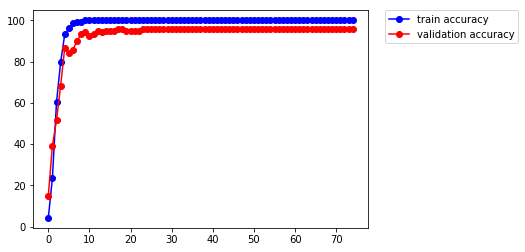

[75/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


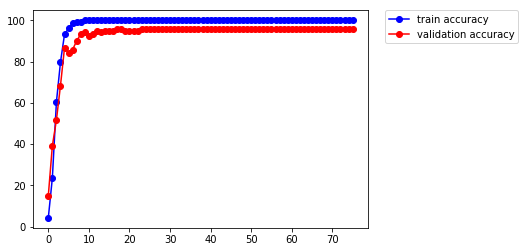

[76/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


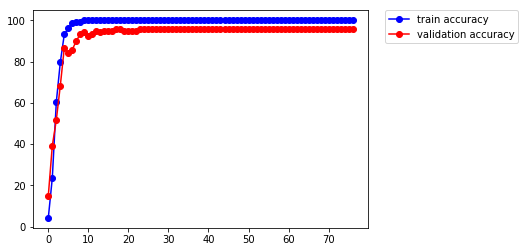

[77/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


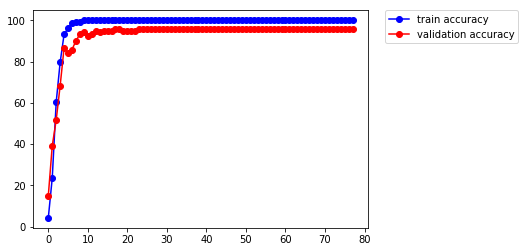

[78/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


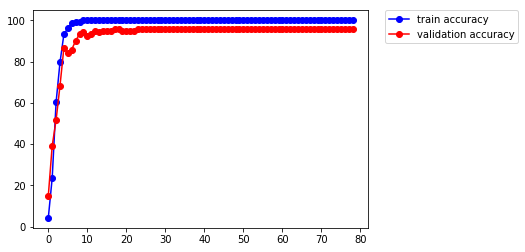

[79/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


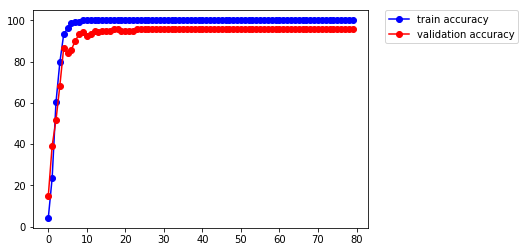

[80/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


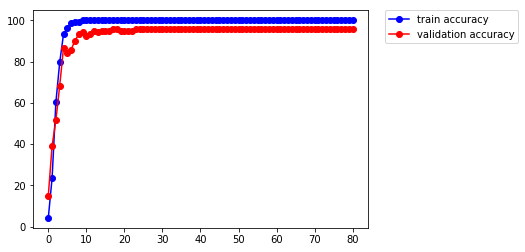

[81/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


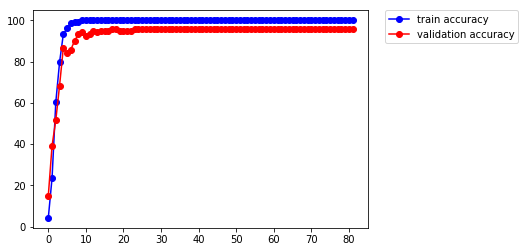

[82/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


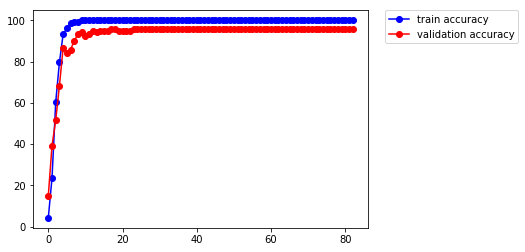

[83/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


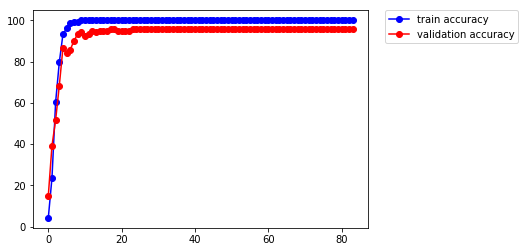

[84/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


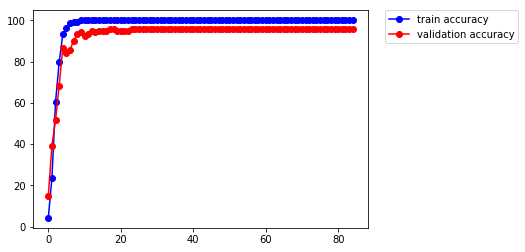

[85/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


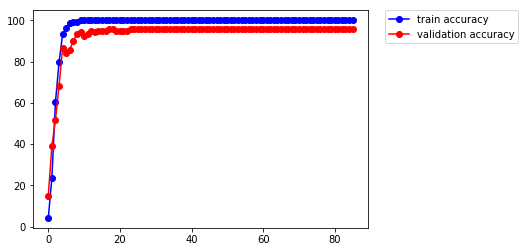

[86/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


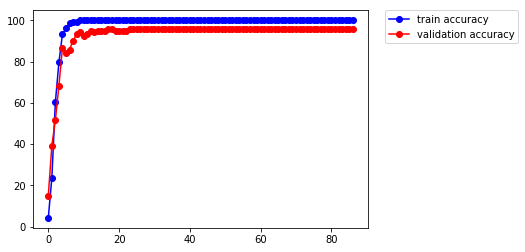

[87/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


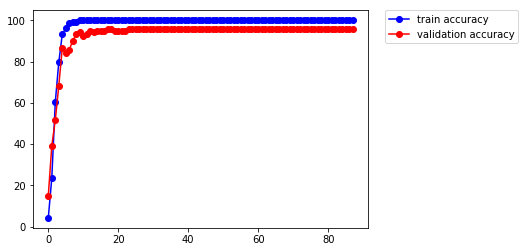

[88/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


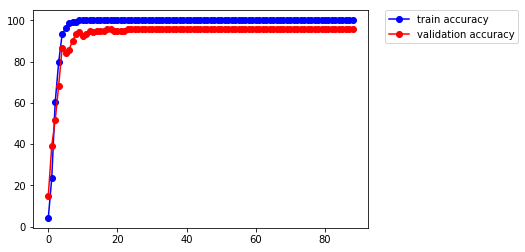

[89/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


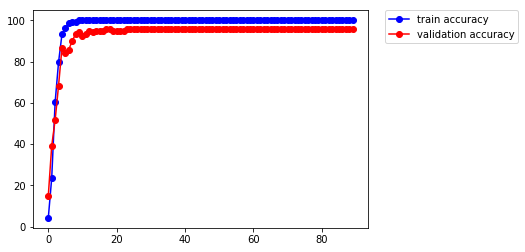

[90/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


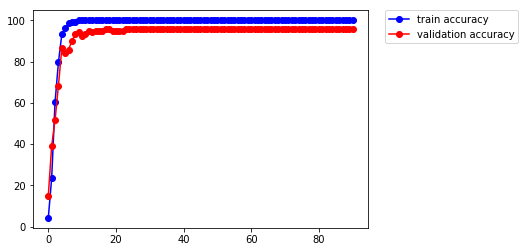

[91/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


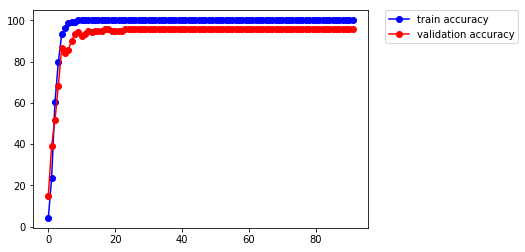

[92/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


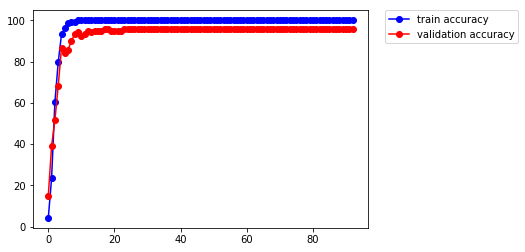

[93/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


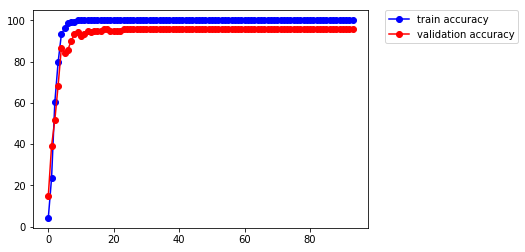

[94/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


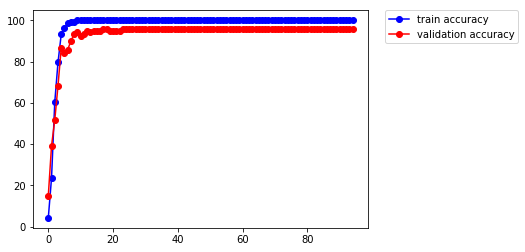

[95/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


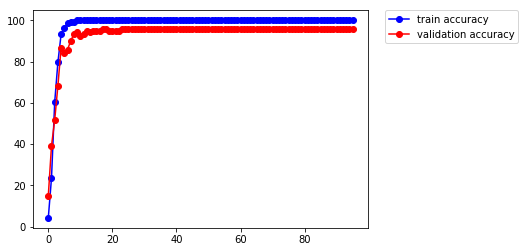

[96/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


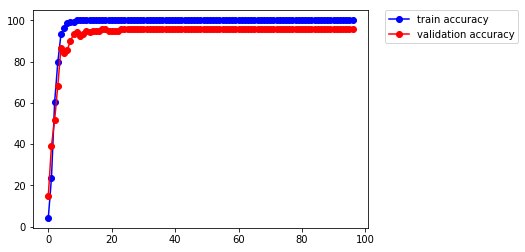

[97/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


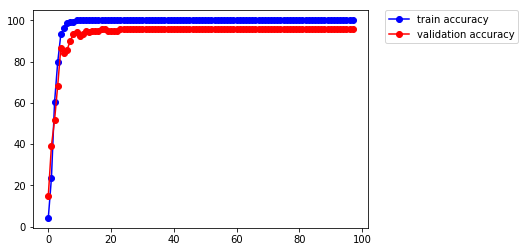

[98/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


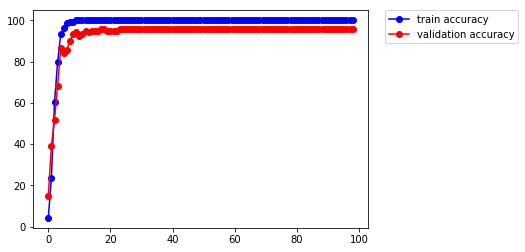

[99/100]

Total accuracy = 95.83 %


Train Accuracy 100.000000


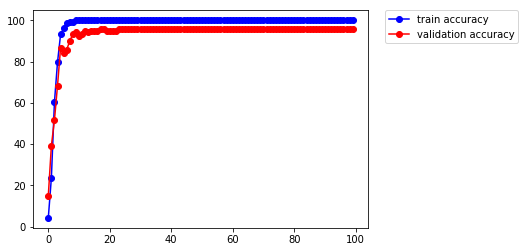

In [187]:
train(net2, trainloader, testloader, optimizer2, criterion, n_epochs, verbose=False)

In [188]:
from torch.autograd import Variable
from torchvision import transforms, utils
normalise = transforms.Normalize(
    mean=[0.5, 0.5, 0.5],
    std=[0.5, 0.5, 0.5]
    )

preprocess = transforms.Compose([
     transforms.Resize((112,92)),
#     transforms.Resize((256,256)),   
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    normalise
    
    ])
def deprocess(image):
    return image * torch.Tensor([0.5]).cuda()  + torch.Tensor([0.5]).cuda()


alpha_reg_alpha = 6
def alpha_norm(input_matrix, alpha):
        """
            Converts matrix to vector then calculates the alpha norm
        """
        alpha_norm = ((input_matrix.view(-1))**alpha).sum()
        return alpha_norm
def denoise(im):
    dream = im.squeeze().cpu().detach().numpy()

    patch_kw = dict(patch_size=5,      # 5x5 patches
                    patch_distance=6,  # 13x13 search area
                    multichannel=False)

    sigma_est = np.mean(estimate_sigma(dream, multichannel=False))
    print(sigma_est)
    df = denoise_nl_means(dream, h=0.75 * sigma_est, fast_mode=True,
                                **patch_kw)
#     plt.imshow(df,cmap='gray')
#     plt.show()
#     denoise_fast = Image.fromarray(np.uint8(denoise_fast))
    return Variable(torch.Tensor(df).unsqueeze(0).cuda(), requires_grad=True)


def ga(image, net, iterations, lr,category):        
    category = Variable(torch.cuda.LongTensor([category]))
    input = Variable(image.unsqueeze(0).cuda(), requires_grad=True)
    losses=[]
    v=0
#     input=image
    for j in range(iterations):
        for i in range(1):

            net.zero_grad()
            out = nn.functional.softmax(net(input), dim=1)
#             out = net(input)
            reg_alpha = alpha_norm(input, alpha_reg_alpha)/1000
            reg_blur = torch.sum((tensorBlur(input.squeeze(),3)-input.squeeze())**2)
            loss= -out.take(category)#+reg_blur/300#+reg_alpha
#             print(torch.sum((tensorBlur(input.squeeze(),5)-input.squeeze())**2))
            loss.backward()
#             v = 0.8* v - lr * input.grad.data
#             v = v.clamp(-.02,.02)
            input.data = input.data - lr * input.grad.data
#             input.data = input.data + v
#             input.data = input.clamp(-1,1)
        print(loss.data)
#         print(reg_alpha)
#         print(-out.take(category))
        losses.append(loss.data)
        print(j)
#         input.data = tensorBlur(input.squeeze(),7)
#         input.data = tensorSharpen(input.data,7).unsqueeze(0)
        plt.imshow(input.squeeze().cpu().detach().numpy(),cmap = 'gray',vmin =-1 , vmax = 1)
        plt.show()
#         plt.imsave(f"Results/Fred {j}.png",input.squeeze().cpu().detach().numpy(),cmap = 'gray',vmin =-1 , vmax = 1,format='png')
    plt.plot(losses)
    plt.show()
#         input = denoise(input)

    
    return input

In [189]:
# torch_page = torch.Tensor((np_page)).unsqueeze(0).cuda()

# plt.plot(net(dream_ga2).squeeze().cpu().detach().numpy())
# print(np.linalg.norm(net(dream_ga2).squeeze().cpu().detach().numpy())/net(dream_ga2).squeeze().cpu().detach().numpy().max())

# plt.show()
# plt.plot(net(dream_ga).squeeze().cpu().detach().numpy())
# print(np.linalg.norm(net(dream_ga).squeeze().cpu().detach().numpy())/net(dream_ga).squeeze().cpu().detach().numpy().max())
# plt.show()
# plt.plot(net2(dream_ga).squeeze().cpu().detach().numpy())
# print(np.linalg.norm(net2(dream_ga).squeeze().cpu().detach().numpy())/net2(dream_ga).squeeze().cpu().detach().numpy().max())
# plt.show()
# plt.plot(net2(dream_ga2).squeeze().cpu().detach().numpy())
# print(np.linalg.norm(net2(dream_ga2).squeeze().cpu().detach().numpy())/net2(dream_ga2).squeeze().cpu().detach().numpy().max())
# plt.show()

In [190]:
# import os
# import imageio

# png_dir = 'png/'
# images = []
# # for file_name in os.listdir(png_dir):
# for i in range(100):
#     filename = f"Results/Fred {i}.png" 
# #     if file_name.endswith('dog_dream_%i.png' %(i)):
# #     file_path = os.path.join(png_dir, file_name)
#     images.append(imageio.imread(filename))
        
# kargs = { 'duration': 0.1 }
# imageio.mimsave('movie.gif', images,**kargs)


tensor(1.00000e-02 *
       [-2.4876], device='cuda:0')
0


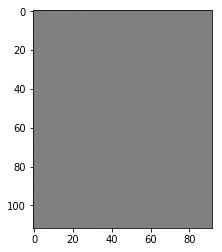

tensor(1.00000e-02 *
       [-2.7925], device='cuda:0')
1


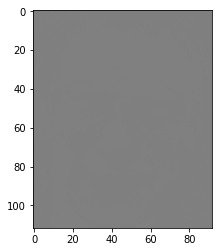

tensor(1.00000e-02 *
       [-3.5614], device='cuda:0')
2


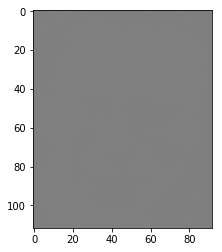

tensor(1.00000e-02 *
       [-5.3088], device='cuda:0')
3


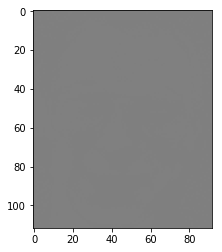

tensor(1.00000e-02 *
       [-9.7712], device='cuda:0')
4


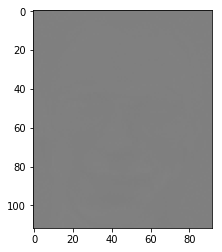

tensor([-0.2408], device='cuda:0')
5


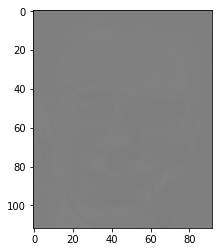

tensor([-0.6834], device='cuda:0')
6


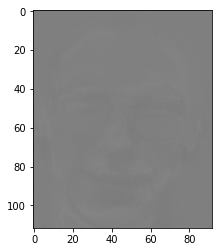

tensor([-0.9744], device='cuda:0')
7


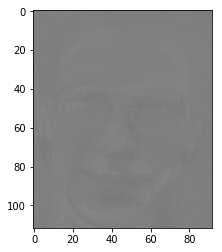

tensor([-0.9986], device='cuda:0')
8


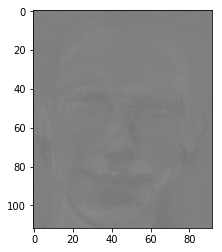

tensor([-0.9999], device='cuda:0')
9


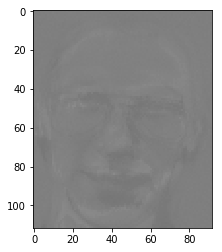

tensor([-1.0000], device='cuda:0')
10


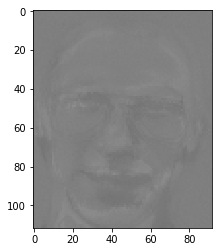

tensor([-1.], device='cuda:0')
11


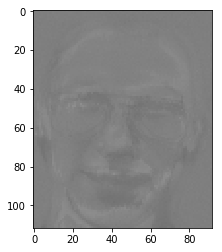

tensor([-1.], device='cuda:0')
12


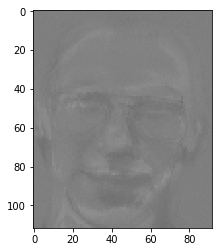

tensor([-1.], device='cuda:0')
13


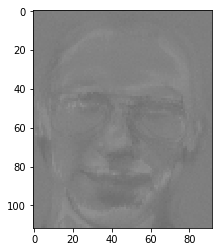

tensor([-1.], device='cuda:0')
14


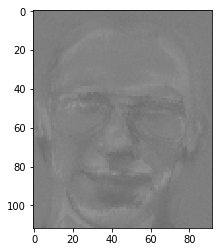

tensor([-1.], device='cuda:0')
15


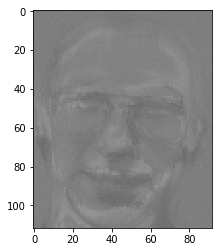

tensor([-1.], device='cuda:0')
16


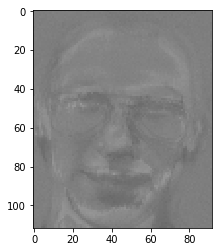

tensor([-1.], device='cuda:0')
17


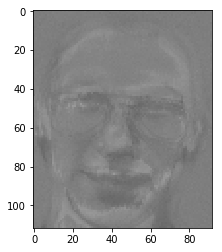

tensor([-1.], device='cuda:0')
18


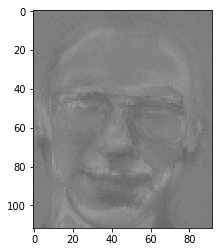

tensor([-1.], device='cuda:0')
19


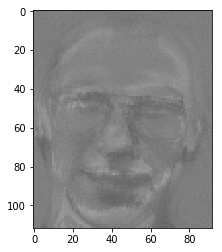

tensor([-1.], device='cuda:0')
20


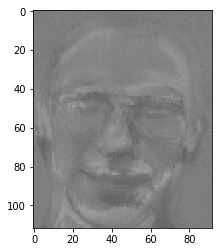

tensor([-1.], device='cuda:0')
21


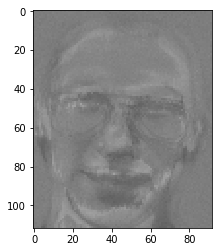

tensor([-1.], device='cuda:0')
22


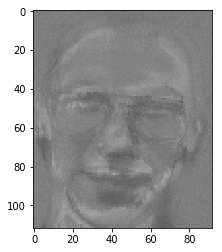

tensor([-1.], device='cuda:0')
23


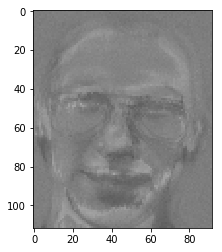

tensor([-1.], device='cuda:0')
24


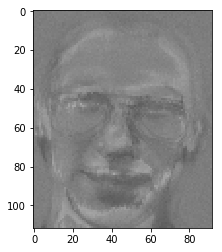

tensor([-1.], device='cuda:0')
25


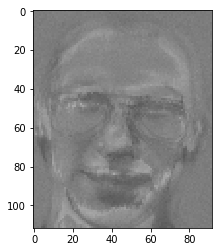

tensor([-1.], device='cuda:0')
26


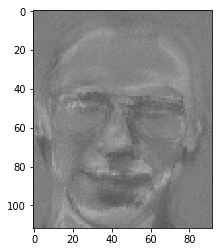

tensor([-1.], device='cuda:0')
27


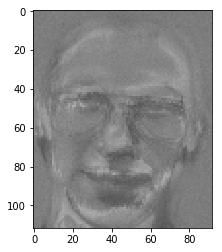

tensor([-1.], device='cuda:0')
28


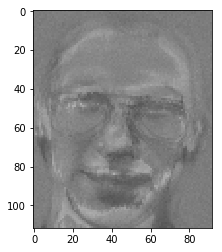

tensor([-1.], device='cuda:0')
29


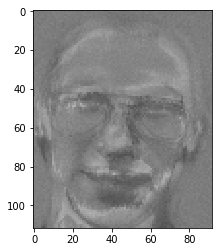

tensor([-1.], device='cuda:0')
30


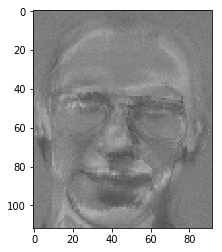

tensor([-1.], device='cuda:0')
31


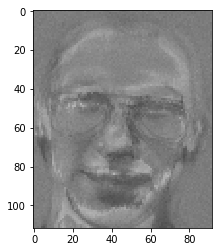

tensor([-1.], device='cuda:0')
32


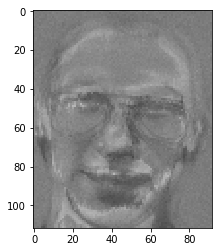

tensor([-1.], device='cuda:0')
33


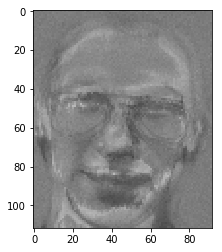

tensor([-1.], device='cuda:0')
34


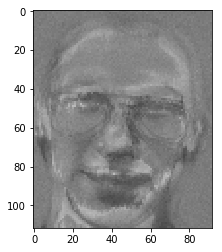

tensor([-1.], device='cuda:0')
35


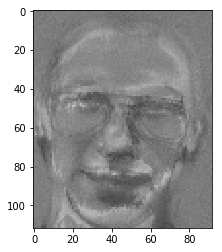

tensor([-1.], device='cuda:0')
36


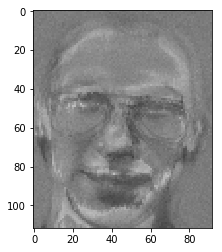

tensor([-1.], device='cuda:0')
37


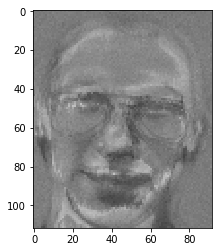

tensor([-1.], device='cuda:0')
38


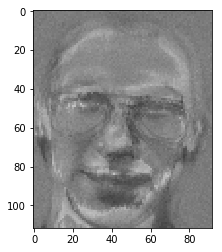

tensor([-1.], device='cuda:0')
39


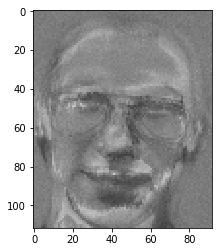

tensor([-1.], device='cuda:0')
40


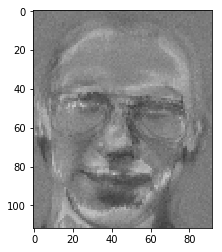

tensor([-1.], device='cuda:0')
41


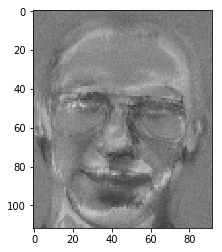

tensor([-1.], device='cuda:0')
42


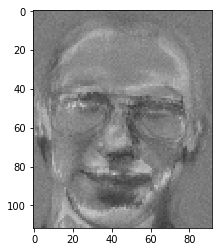

tensor([-1.], device='cuda:0')
43


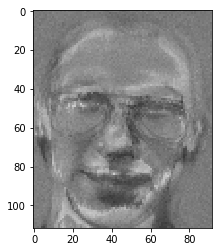

tensor([-1.], device='cuda:0')
44


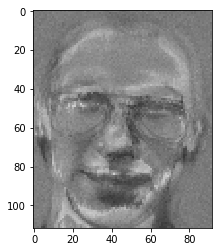

tensor([-1.], device='cuda:0')
45


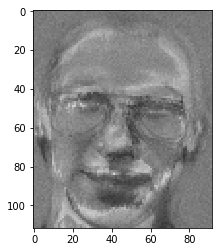

tensor([-1.], device='cuda:0')
46


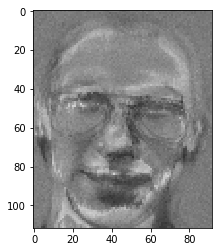

tensor([-1.], device='cuda:0')
47


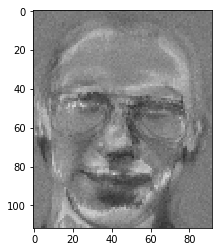

tensor([-1.], device='cuda:0')
48


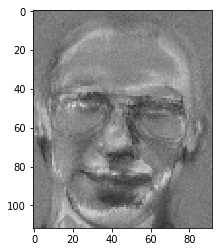

tensor([-1.], device='cuda:0')
49


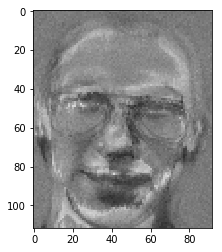

tensor([-1.], device='cuda:0')
50


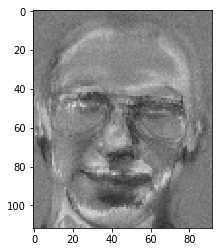

tensor([-1.], device='cuda:0')
51


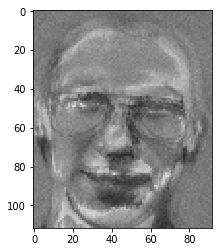

tensor([-1.], device='cuda:0')
52


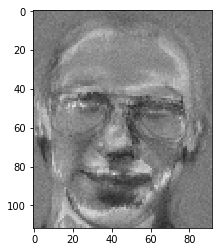

tensor([-1.], device='cuda:0')
53


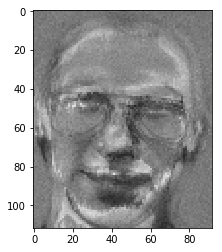

tensor([-1.], device='cuda:0')
54


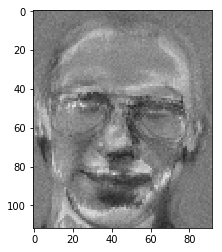

tensor([-1.], device='cuda:0')
55


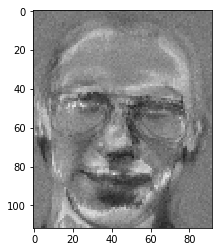

tensor([-1.], device='cuda:0')
56


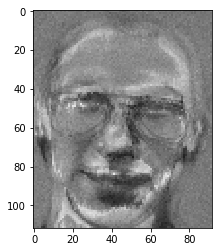

tensor([-1.], device='cuda:0')
57


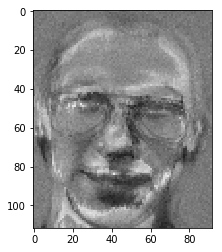

tensor([-1.], device='cuda:0')
58


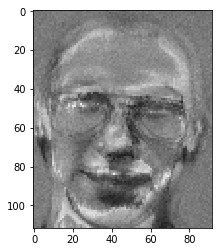

tensor([-1.], device='cuda:0')
59


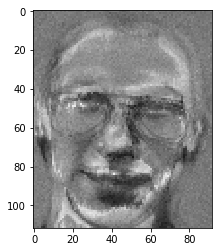

tensor([-1.], device='cuda:0')
60


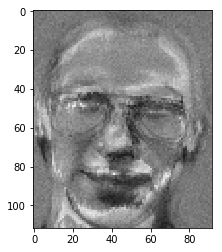

tensor([-1.], device='cuda:0')
61


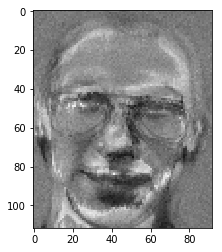

tensor([-1.], device='cuda:0')
62


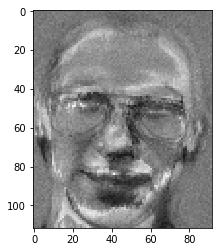

tensor([-1.], device='cuda:0')
63


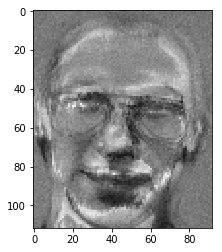

tensor([-1.], device='cuda:0')
64


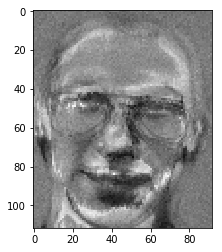

tensor([-1.], device='cuda:0')
65


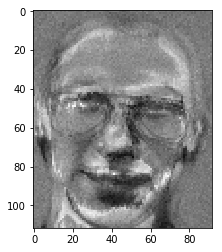

tensor([-1.], device='cuda:0')
66


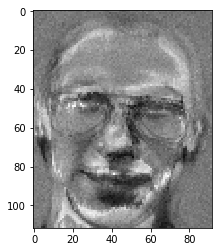

tensor([-1.], device='cuda:0')
67


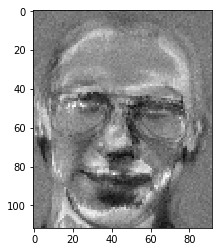

tensor([-1.], device='cuda:0')
68


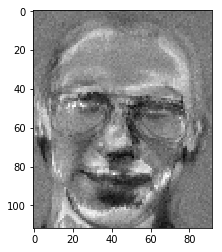

tensor([-1.], device='cuda:0')
69


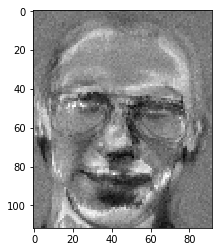

tensor([-1.], device='cuda:0')
70


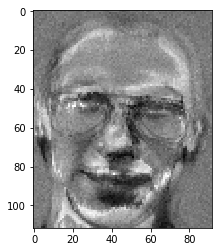

tensor([-1.], device='cuda:0')
71


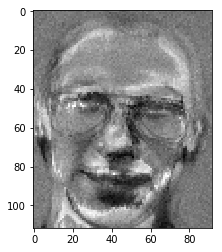

tensor([-1.], device='cuda:0')
72


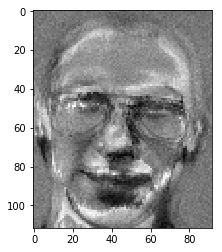

tensor([-1.], device='cuda:0')
73


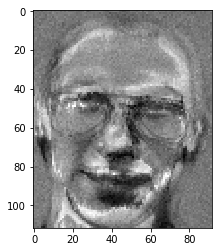

tensor([-1.], device='cuda:0')
74


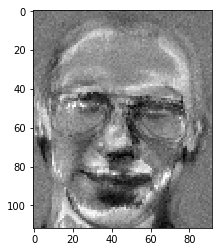

tensor([-1.], device='cuda:0')
75


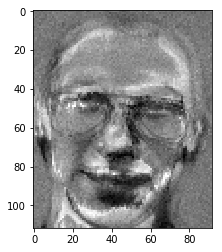

tensor([-1.], device='cuda:0')
76


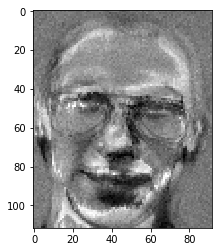

tensor([-1.], device='cuda:0')
77


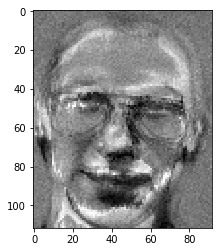

tensor([-1.], device='cuda:0')
78


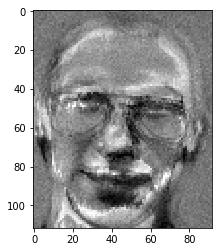

tensor([-1.], device='cuda:0')
79


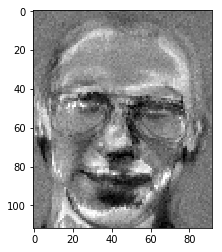

tensor([-1.], device='cuda:0')
80


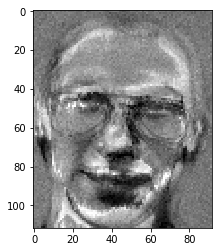

tensor([-1.], device='cuda:0')
81


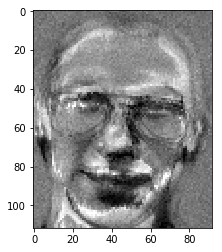

tensor([-1.], device='cuda:0')
82


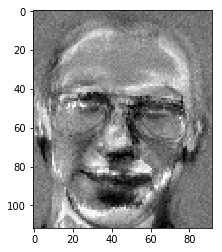

tensor([-1.], device='cuda:0')
83


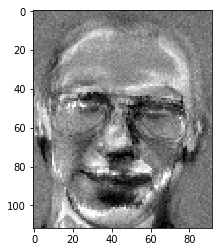

tensor([-1.], device='cuda:0')
84


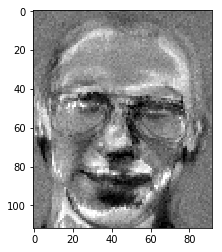

tensor([-1.], device='cuda:0')
85


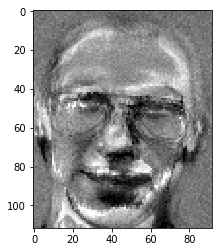

tensor([-1.], device='cuda:0')
86


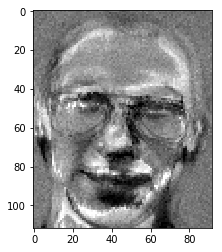

tensor([-1.], device='cuda:0')
87


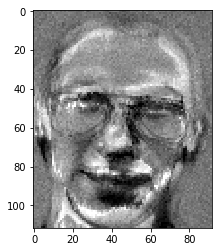

tensor([-1.], device='cuda:0')
88


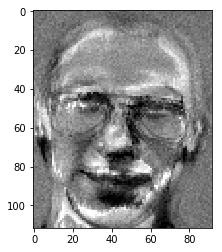

tensor([-1.], device='cuda:0')
89


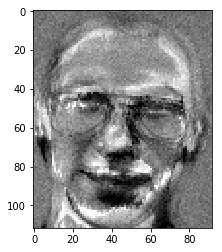

tensor([-1.], device='cuda:0')
90


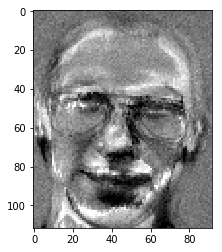

tensor([-1.], device='cuda:0')
91


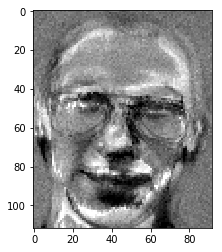

tensor([-1.], device='cuda:0')
92


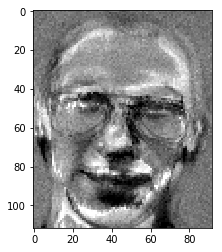

tensor([-1.], device='cuda:0')
93


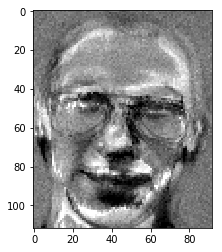

tensor([-1.], device='cuda:0')
94


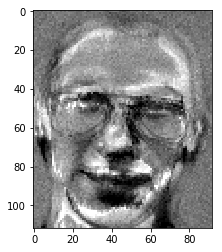

tensor([-1.], device='cuda:0')
95


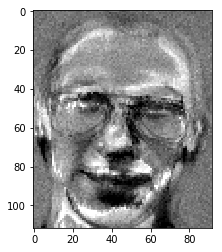

tensor([-1.], device='cuda:0')
96


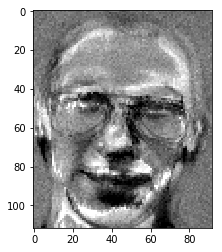

tensor([-1.], device='cuda:0')
97


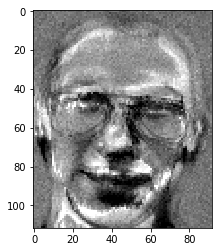

tensor([-1.], device='cuda:0')
98


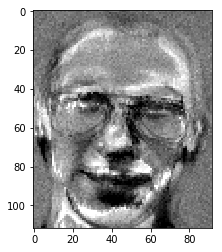

tensor([-1.], device='cuda:0')
99


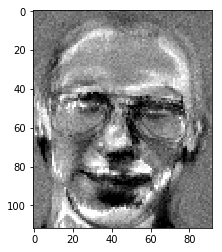

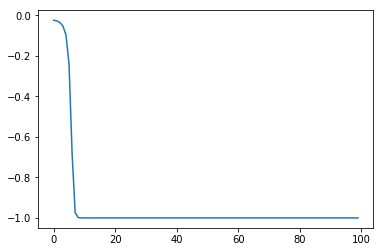

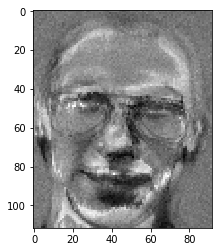

In [191]:
np_page=np.ones((112,92))*0#-1e-1#1.00000e-02*8.6196
dream_ga=ga(torch.Tensor((np_page)),net,100,1e-1,32)
plt.imshow(dream_ga.squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()

tensor(1.00000e-02 *
       [-2.4731], device='cuda:0')
0


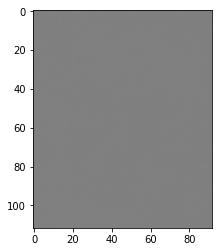

tensor(1.00000e-02 *
       [-2.4865], device='cuda:0')
1


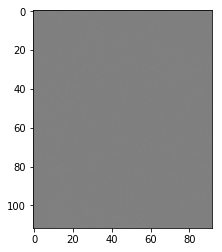

tensor(1.00000e-02 *
       [-2.5135], device='cuda:0')
2


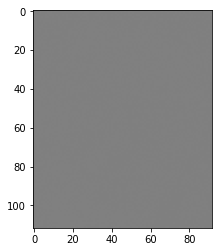

tensor(1.00000e-02 *
       [-2.5549], device='cuda:0')
3


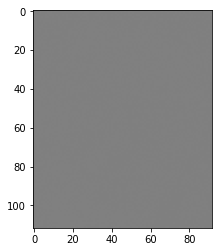

tensor(1.00000e-02 *
       [-2.6114], device='cuda:0')
4


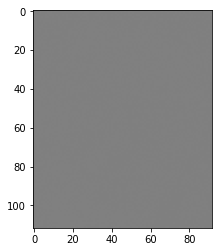

tensor(1.00000e-02 *
       [-2.6843], device='cuda:0')
5


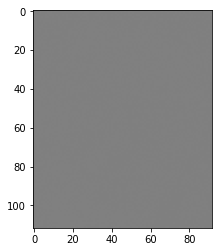

tensor(1.00000e-02 *
       [-2.7753], device='cuda:0')
6


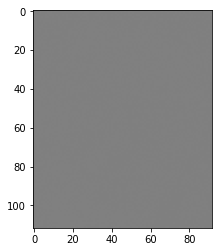

tensor(1.00000e-02 *
       [-2.8867], device='cuda:0')
7


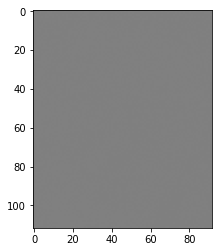

tensor(1.00000e-02 *
       [-3.0211], device='cuda:0')
8


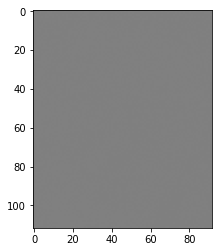

tensor(1.00000e-02 *
       [-3.1823], device='cuda:0')
9


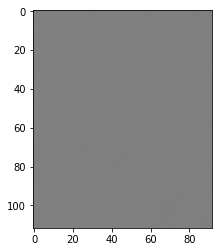

tensor(1.00000e-02 *
       [-3.3748], device='cuda:0')
10


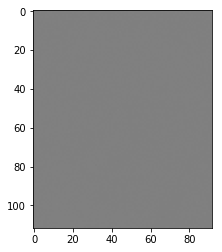

tensor(1.00000e-02 *
       [-3.6044], device='cuda:0')
11


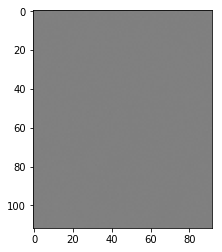

tensor(1.00000e-02 *
       [-3.8786], device='cuda:0')
12


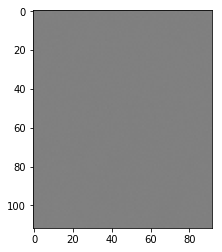

tensor(1.00000e-02 *
       [-4.2071], device='cuda:0')
13


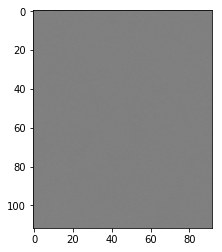

tensor(1.00000e-02 *
       [-4.6025], device='cuda:0')
14


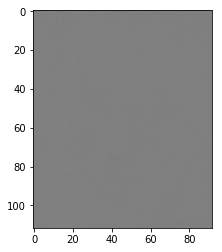

tensor(1.00000e-02 *
       [-5.0815], device='cuda:0')
15


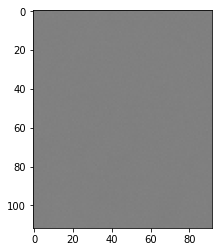

tensor(1.00000e-02 *
       [-5.6663], device='cuda:0')
16


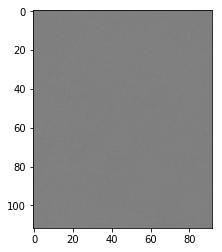

tensor(1.00000e-02 *
       [-6.3867], device='cuda:0')
17


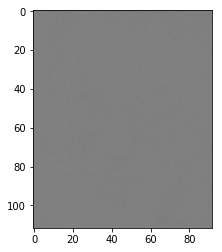

tensor(1.00000e-02 *
       [-7.2838], device='cuda:0')
18


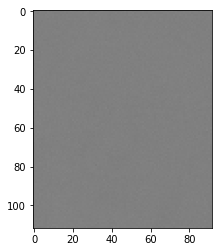

tensor(1.00000e-02 *
       [-8.4142], device='cuda:0')
19


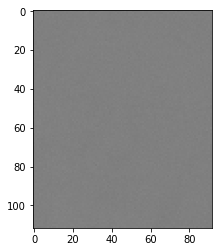

tensor(1.00000e-02 *
       [-9.8574], device='cuda:0')
20


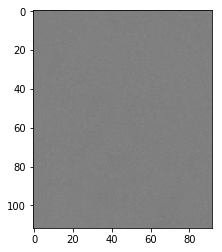

tensor([-0.1173], device='cuda:0')
21


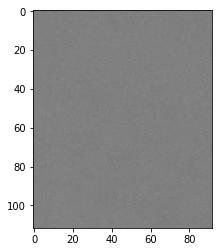

tensor([-0.1418], device='cuda:0')
22


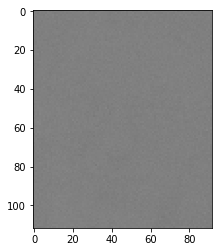

tensor([-0.1745], device='cuda:0')
23


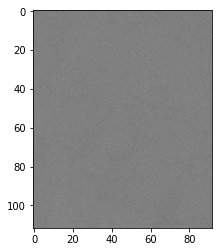

tensor([-0.2184], device='cuda:0')
24


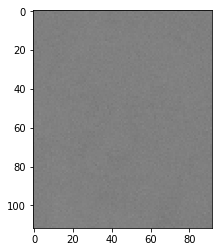

tensor([-0.2775], device='cuda:0')
25


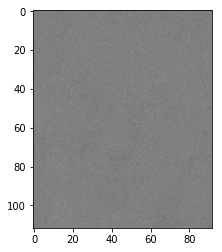

tensor([-0.3559], device='cuda:0')
26


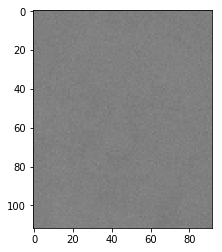

tensor([-0.4559], device='cuda:0')
27


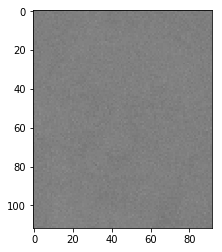

tensor([-0.5736], device='cuda:0')
28


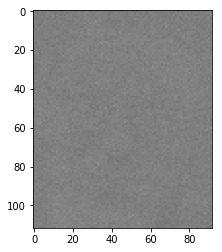

tensor([-0.6954], device='cuda:0')
29


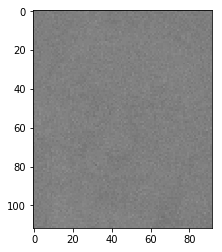

tensor([-0.8026], device='cuda:0')
30


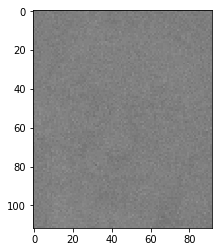

tensor([-0.8824], device='cuda:0')
31


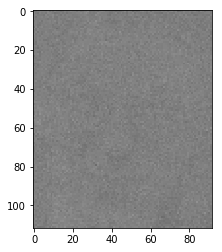

tensor([-0.9342], device='cuda:0')
32


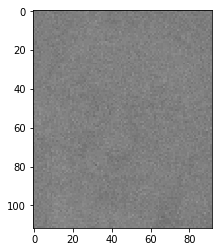

tensor([-0.9645], device='cuda:0')
33


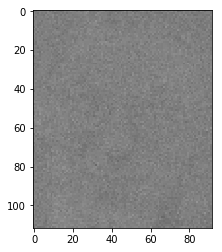

tensor([-0.9813], device='cuda:0')
34


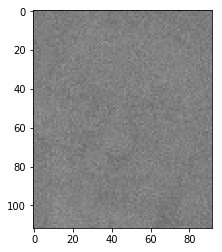

tensor([-0.9903], device='cuda:0')
35


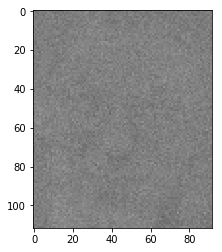

tensor([-0.9950], device='cuda:0')
36


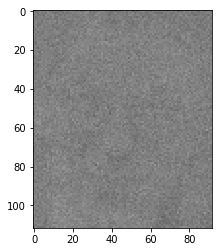

tensor([-0.9974], device='cuda:0')
37


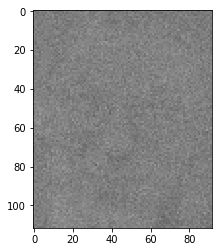

tensor([-0.9987], device='cuda:0')
38


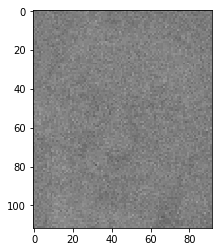

tensor([-0.9993], device='cuda:0')
39


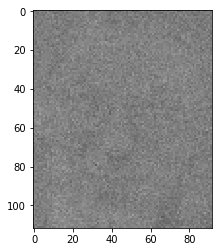

tensor([-0.9996], device='cuda:0')
40


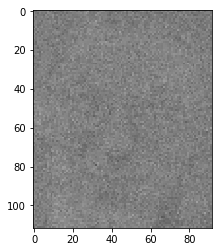

tensor([-0.9998], device='cuda:0')
41


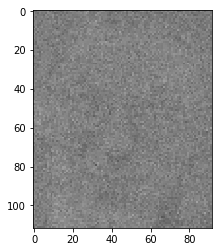

tensor([-0.9999], device='cuda:0')
42


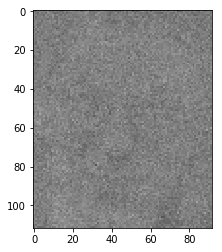

tensor([-1.0000], device='cuda:0')
43


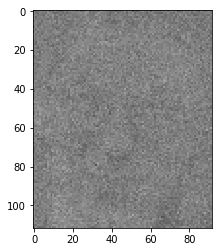

tensor([-1.0000], device='cuda:0')
44


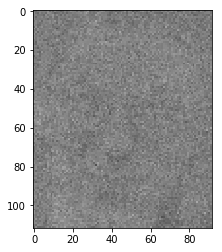

tensor([-1.0000], device='cuda:0')
45


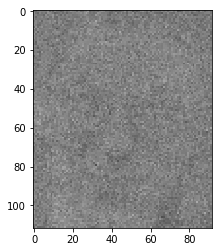

tensor([-1.0000], device='cuda:0')
46


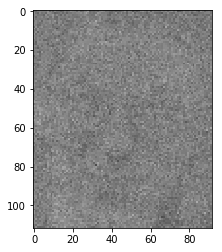

tensor([-1.0000], device='cuda:0')
47


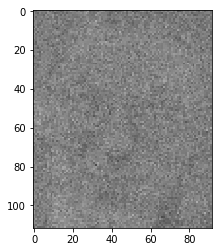

tensor([-1.0000], device='cuda:0')
48


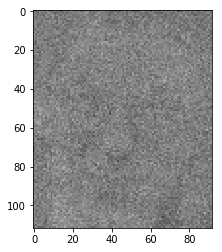

tensor([-1.0000], device='cuda:0')
49


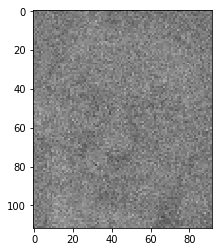

tensor([-1.], device='cuda:0')
50


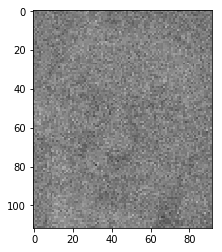

tensor([-1.], device='cuda:0')
51


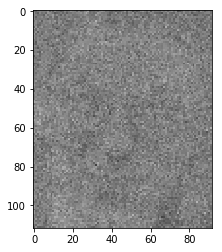

tensor([-1.], device='cuda:0')
52


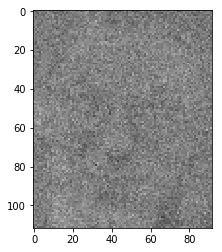

tensor([-1.], device='cuda:0')
53


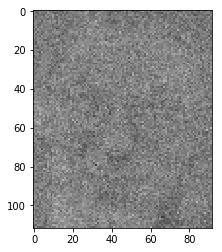

tensor([-1.], device='cuda:0')
54


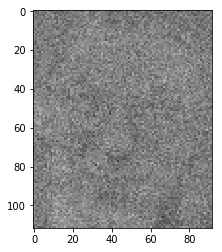

tensor([-1.], device='cuda:0')
55


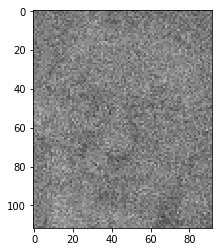

tensor([-1.], device='cuda:0')
56


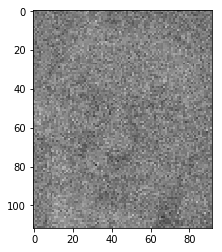

tensor([-1.], device='cuda:0')
57


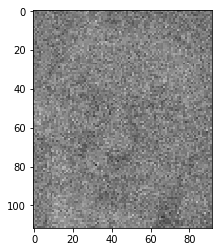

tensor([-1.], device='cuda:0')
58


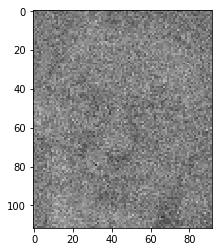

tensor([-1.], device='cuda:0')
59


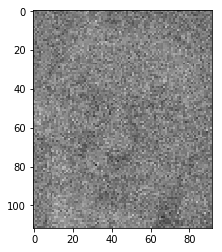

tensor([-1.], device='cuda:0')
60


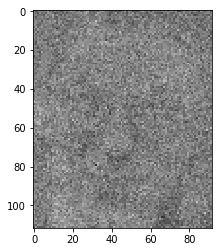

tensor([-1.], device='cuda:0')
61


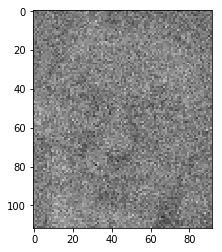

tensor([-1.], device='cuda:0')
62


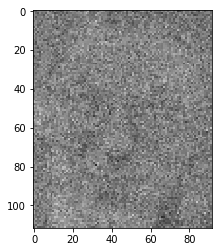

tensor([-1.], device='cuda:0')
63


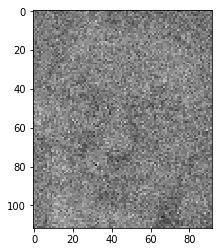

tensor([-1.], device='cuda:0')
64


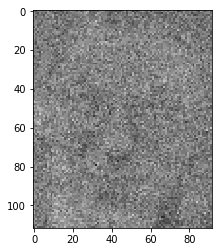

tensor([-1.], device='cuda:0')
65


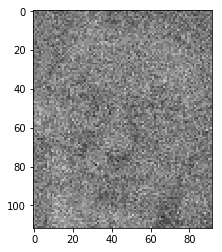

tensor([-1.], device='cuda:0')
66


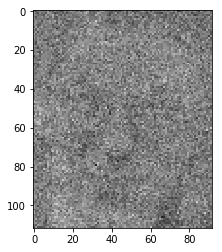

tensor([-1.], device='cuda:0')
67


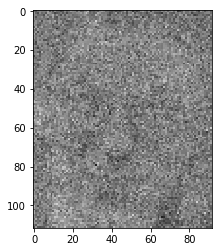

tensor([-1.], device='cuda:0')
68


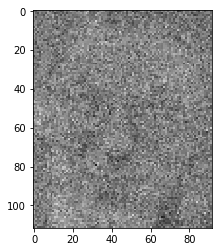

tensor([-1.], device='cuda:0')
69


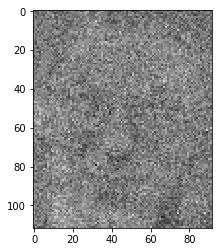

tensor([-1.], device='cuda:0')
70


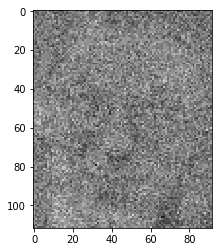

tensor([-1.], device='cuda:0')
71


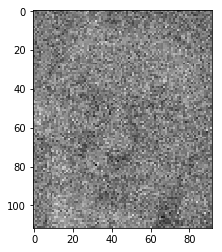

tensor([-1.], device='cuda:0')
72


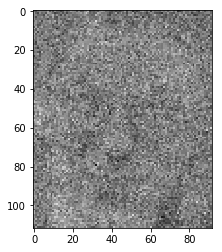

tensor([-1.], device='cuda:0')
73


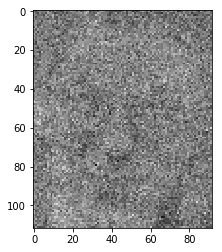

tensor([-1.], device='cuda:0')
74


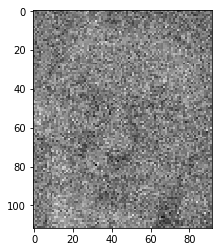

tensor([-1.], device='cuda:0')
75


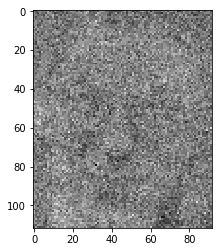

tensor([-1.], device='cuda:0')
76


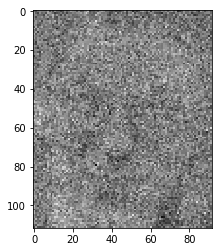

tensor([-1.], device='cuda:0')
77


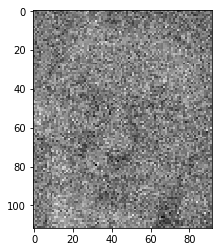

tensor([-1.], device='cuda:0')
78


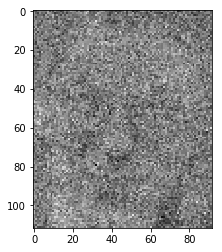

tensor([-1.], device='cuda:0')
79


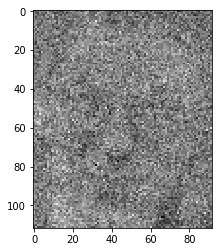

tensor([-1.], device='cuda:0')
80


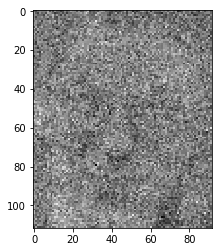

tensor([-1.], device='cuda:0')
81


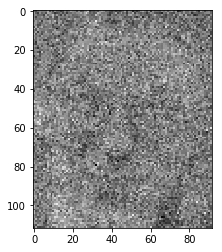

tensor([-1.], device='cuda:0')
82


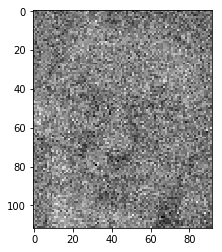

tensor([-1.], device='cuda:0')
83


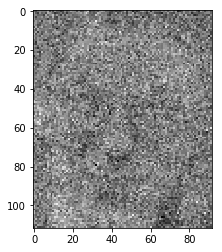

tensor([-1.], device='cuda:0')
84


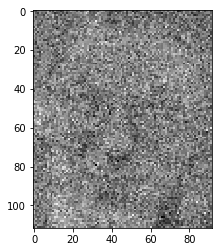

tensor([-1.], device='cuda:0')
85


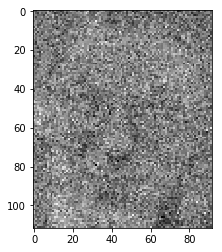

tensor([-1.], device='cuda:0')
86


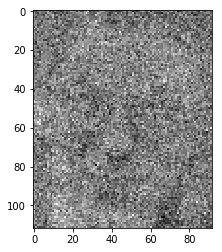

tensor([-1.], device='cuda:0')
87


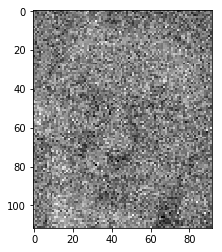

tensor([-1.], device='cuda:0')
88


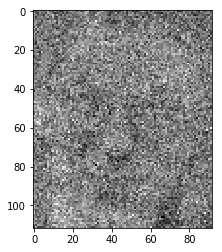

tensor([-1.], device='cuda:0')
89


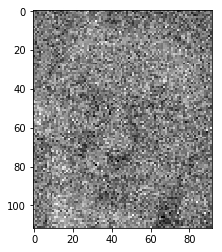

tensor([-1.], device='cuda:0')
90


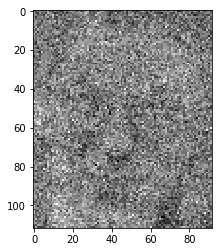

tensor([-1.], device='cuda:0')
91


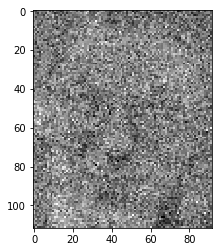

tensor([-1.], device='cuda:0')
92


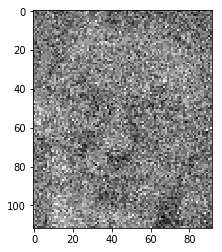

tensor([-1.], device='cuda:0')
93


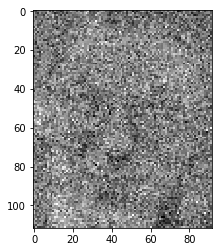

tensor([-1.], device='cuda:0')
94


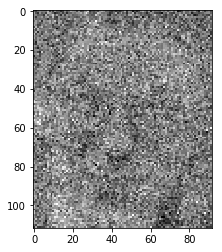

tensor([-1.], device='cuda:0')
95


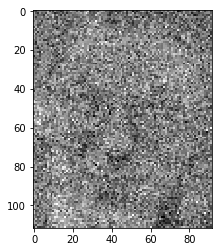

tensor([-1.], device='cuda:0')
96


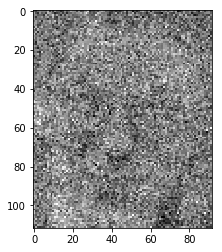

tensor([-1.], device='cuda:0')
97


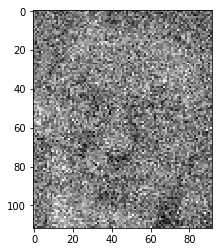

tensor([-1.], device='cuda:0')
98


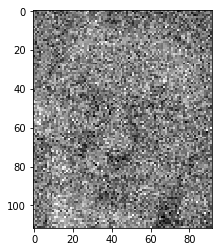

tensor([-1.], device='cuda:0')
99


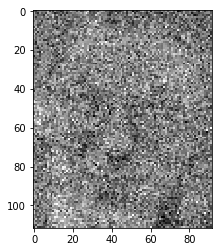

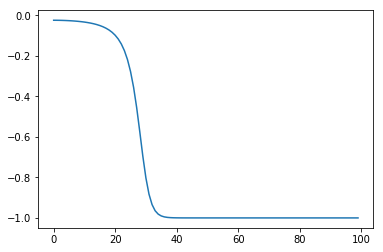

tensor(1.00000e-04 *
       -6.9151, device='cuda:0')


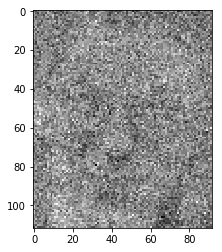

In [192]:
np_page=np.ones((112,92))*0#-1e-1#1.00000e-02*8.6196
dream_ga2=ga(torch.Tensor((np_page)),net2,100,1e-1,32)
print(dream_ga2.mean())
plt.imshow(dream_ga2.squeeze().cpu().detach().numpy(),cmap='gray')

In [215]:
for i, batch in enumerate(testloader):
    imgs, labels = batch
    imgs, labels = imgs.to(device), labels.to(device)

    out = netAE(imgs)
    out = out.reshape(-1,1,112,92)
    print(torch.sum(torch.abs(imgs-out))/out.size(0))

tensor(2045.5737, device='cuda:0')
tensor(2016.0499, device='cuda:0')
tensor(2016.2177, device='cuda:0')
tensor(2013.8684, device='cuda:0')


In [216]:
for i, batch in enumerate(trainloader):
    imgs, labels = batch
    imgs, labels = imgs.to(device), labels.to(device)

    out = netAE(imgs)
    out = out.reshape(-1,1,112,92)
    print(torch.sum(torch.abs(imgs-out))/out.size(0))

tensor(1962.8668, device='cuda:0')
tensor(2004.9456, device='cuda:0')
tensor(1982.0225, device='cuda:0')


24

torch.Size([40, 10304])


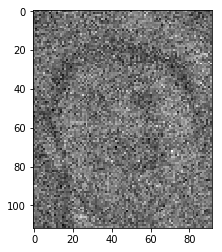

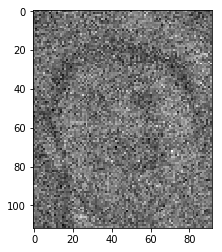

In [217]:
class ae(nn.Module): 
    def __init__(self, n_in=112*92, n_out=40, n_hidden=3000): 
        super(ae, self).__init__()
        
        self.hidden1 = nn.Linear(n_in, n_out)        
        self.hidden2 = nn.Linear(n_out, n_in)
    def forward(self, x):
        x = x.view(-1,112*92)
        x = self.hidden1(x)
        out = self.hidden2(x)
        
        return out
    
netAE = ae().to(device)
# net.apply(models.weights_init)
# print(netAE.hidden1.weight.data.size())
ainv = np.linalg.pinv(net2.hidden1.weight.data)
# print(ainv.shape)
# print(netAE.hidden2.weight.data.size())
netAE.hidden1.weight.data = net2.hidden1.weight.data
netAE.hidden2.weight.data = torch.tensor(ainv).to(device)
netAE.hidden1.bias.data = torch.tensor(0.0).to(device)
netAE.hidden2.bias.data = torch.tensor(0.0).to(device)

ww = net2.hidden1.weight.data
bb = net2.hidden1.bias.data
print(ww.size())
# print(net.hidden1.bias)
im = ww[34,:].squeeze().cpu().detach().numpy().reshape(112,92)
plt.imshow(im,cmap='gray')
plt.show()
# print(ww.mean())
# imAE = netAE(torch.tensor(np.flipud(im).flatten()).unsqueeze(0).to(device))
imAE = netAE(ww[34,:].to(device))
# imAE = netAE(imgs.squeeze().reshape(112*92).unsqueeze(0).to(device))
plt.imshow(imAE.squeeze().cpu().detach().numpy().reshape(112,92),cmap='gray')
plt.show()
# imAE = netAE(imgs.squeeze().reshape(112*92).unsqueeze(0).to(device))
# plt.imshow(imAE.squeeze().cpu().detach().numpy().reshape(112,92),cmap='gray')
# plt.show()

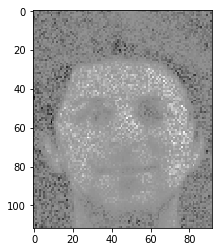

tensor(0.9268, device='cuda:0')
tensor(-1.2770, device='cuda:0')


In [195]:
out_sum = torch.cuda.FloatTensor(np.zeros((1,112,92)))
n = torch.cuda.FloatTensor(np.zeros((1)))
# for j in range(100):
for i, batch in enumerate(testloader):
    imgs, labels = batch
    imgs, labels = imgs.to(device), labels.to(device)
#     r = torch.randn((1, 1, 1)).to(device)
#     imgs = torch.from_numpy(np.flipud(imgs.permute(2,3,1,0).cpu().detach().numpy()).copy()).to(device).permute(3,2,0,1)
#         imgs = torch.randn(imgs.size()).to(device)/2 + imgs
#         imgs = torch.randn(imgs.size()).to(device) + out_sum
    out = nn.functional.softmax(net2(imgs), dim = 1 )
    out_im=(imgs*torch.tensor(np.abs(im)).to(device))
#     out_im=(imgs*imgs*torch.tensor(im).to(device))
#     out_im= imgs
#     out_im=(torch.abs(imgs)*torch.tensor(im).to(device))

    out_sum =  (out_sum * n + torch.sum(out_im*out[:,34].view(-1,1,1,1),dim=0)) / (n + (imgs.size()[0]))
    n = n + (imgs.size()[0])
# plt.imshow(out_sum.squeeze().cpu().detach().numpy(),cmap='gray')
# plt.show() 
#     out_sum + torch.sum(out_im*out[:,34].view(-1,1,1,1),dim=0)
# print(j)
    #     print(imgs.size()[0])
        #     plt.plot(out[:,34].squeeze().cpu().detach().numpy())
        #     plt.show()
        #     if i ==2:
        #         break

    
# plt.imshow(np.flipud(out_sum.squeeze().cpu().detach().numpy()/120),cmap='gray')
plt.imshow(out_sum.squeeze().cpu().detach().numpy(),cmap='gray')
plt.show() 
out_sum1=out_sum
# print(out_sum.size())
# plt.imshow(tensorBlur(out_sum.squeeze(),3).squeeze().cpu().detach().numpy()/120,cmap='gray')
# plt.show() 
print(out_sum.max()*1000)
print(out_sum.min()*1000)

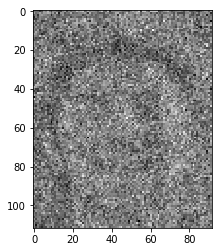

tensor(1.00000e-02 *
       1.1112, device='cuda:0')
tensor(1.00000e-02 *
       -1.0385, device='cuda:0')


In [169]:
out_im = torch.cuda.FloatTensor(np.zeros((1,112,92)))
n = torch.cuda.FloatTensor(np.zeros((1)))
tt=[]
rr=[]
out_sum = out_im
for j in range(100):
    r = torch.randn((1, 1, 1)).to(device)
#     r = torch.ones((1, 112, 92)).to(device)/20
    
    imgs = r + out_im
#     out = nn.functional.softmax(net2(imgs), dim = 1 )
    out_im=(imgs*imgs*torch.tensor((im)).to(device))
    
    imgs = -r + out_im
#     out = nn.functional.softmax(net2(imgs), dim = 1 )       
    out_im=(imgs*imgs*torch.tensor((im)).to(device))
    


plt.imshow(out_im.squeeze().cpu().detach().numpy(),cmap='gray')
plt.show() 

print(out_im.max())
print(out_im.min())



In [ ]:
out_im = torch.cuda.FloatTensor(np.zeros((1,112,92)))
n = torch.cuda.FloatTensor(np.zeros((1)))
tt=[]
rr=[]
out_sum = out_im
for i, batch in enumerate(testloader):
    imgs, labels = batch
    imgs, labels = imgs.to(device), labels.to(device)
    
    r = torch.randn((1, 1, 1)).to(device)
#     r = torch.ones((1, 112, 92)).to(device)/20
    
    imgs = r + out_im
#     out = nn.functional.softmax(net2(imgs), dim = 1 )
    out_im=(imgs*imgs*torch.tensor((im)).to(device))
    
    imgs = -r + out_im
#     out = nn.functional.softmax(net2(imgs), dim = 1 )       
    out_im=(imgs*imgs*torch.tensor((im)).to(device))
    


plt.imshow(out_im.squeeze().cpu().detach().numpy(),cmap='gray')
plt.show() 

print(out_im.max())
print(out_im.min())

In [142]:
np.sum(np.random.randn(100))
# out_sum = torch.cuda.FloatTensor(np.zeros((1,112,92)))
# for i, batch in enumerate(testloader):
#     imgs, labels = batch
#     print(imgs.size()[0])
#     imgs, labels = imgs.to(device), labels.to(device)
#     imgs = torch.randn(imgs.size()).to(device)
#     out = nn.functional.softmax(net2(imgs), dim = 1 )
#     out_im=(imgs*torch.tensor(np.abs(im)).to(device))
#     out_sum = out_sum + torch.sum(out_im*out[:,34].view(-1,1,1,1),dim=0)

    
    
# plt.imshow(out_sum.squeeze().cpu().detach().numpy()/120,cmap='gray')
# plt.show() 
# out1 = nn.functional.softmax(net2(out_sum), dim = 1 )
# plt.plot(out1.squeeze().cpu().detach().numpy())
# plt.show()

7.385242736694317

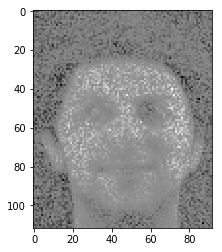

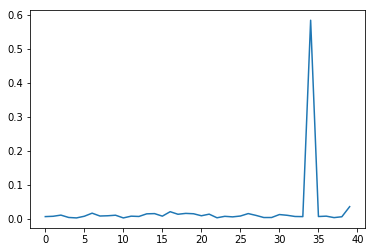

In [66]:
# plt.imshow(np.flipud(out_sum.squeeze().cpu().detach().numpy()/120),cmap='gray')
plt.imshow(out_sum.squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()
out1 = nn.functional.softmax(net2(out_sum*400), dim = 1 )
plt.plot(out1.squeeze().cpu().detach().numpy())
plt.show()
# plt.plot(out[:,34].squeeze().cpu().detach().numpy())
# plt.show()
# imgs.size()
# imgs_flip=np.flipud(imgs.permute(2,3,1,0).cpu().detach().numpy())

# plt.imshow(imgs[3,:,:,:].squeeze().cpu().detach().numpy()*im,cmap='gray')
# plt.show()

tensor(0.9932, device='cuda:0')


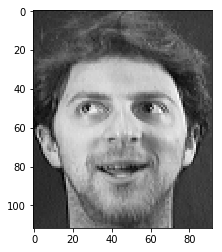

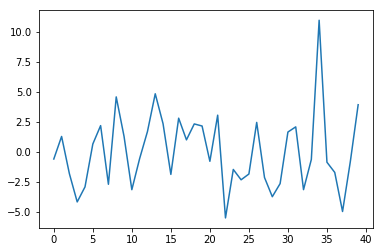

tensor(1.00000e-02 *
       3.1966, device='cuda:0')


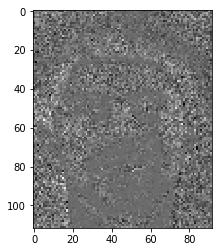

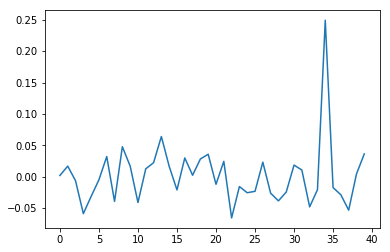

In [550]:
im_num = 3
print(nn.functional.softmax(net2(imgs[im_num,:,:,:]), dim = 1 ).max())
plt.imshow(imgs[im_num,:,:,:].squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()
plt.plot((net2(torch.from_numpy(imgs[im_num,:,:,:].squeeze().cpu().detach().numpy()).to(device))).squeeze().cpu().detach().numpy())
plt.show()



print(nn.functional.softmax(net2(torch.from_numpy(imgs[im_num,:,:,:].squeeze().cpu().detach().numpy()*np.abs(im)).to(device)), dim = 1 ).max())
plt.imshow(imgs[im_num,:,:,:].squeeze().cpu().detach().numpy()*im,cmap='gray')
plt.show()

plt.plot((net2(torch.from_numpy(imgs[im_num,:,:,:].squeeze().cpu().detach().numpy()*np.abs(im)).to(device))).squeeze().cpu().detach().numpy())
plt.show()

# print(((imgs[3,:,:,:].squeeze().cpu().detach().numpy()*im).sum()))
# print(((imgs[3,:,:,:].squeeze().cpu().detach().numpy()*im*im).sum()))


In [538]:
print(im.shape)
print(im.sum())
print((im*im).sum())
print((im*imgs[im_num,:,:,:].squeeze().cpu().detach().numpy()).sum())
print((im*im*imgs[im_num,:,:,:].squeeze().cpu().detach().numpy()).sum())

(112, 92)
1.6267369
2.1379533
10.96107
-0.2625964


tensor(1.00000e-05 *
       3.7970, device='cuda:0')


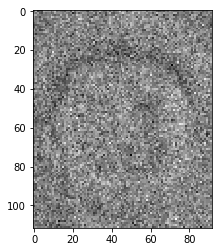

In [253]:
ww=net2.hidden1.weight.data
ww.size()
print(ww.mean())
im = ww[34,:].squeeze().cpu().detach().numpy().reshape(112,92)
plt.imshow(im,cmap='gray')

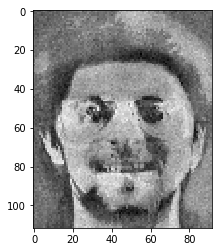

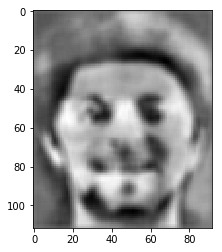

tensor(315.0464, device='cuda:0')


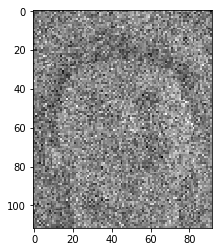

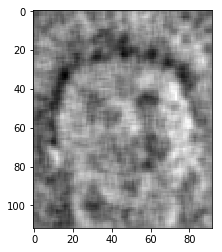

tensor(975.2228, device='cuda:0')


In [290]:
plt.imshow(dream_ga.squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()
plt.imshow(tensorBlur(dream_ga.squeeze(),5).cpu().detach().numpy(),cmap='gray')
plt.show()
# xx = (tensorBlur(dream_ga.squeeze().cpu().detach().numpy(),5)-dream_ga.squeeze())**2

print(torch.sum((tensorBlur(dream_ga.squeeze(),5)-dream_ga.squeeze())**2))
plt.imshow(dream_ga2.squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()
plt.imshow(tensorBlur(dream_ga2.squeeze(),5).cpu().detach().numpy(),cmap='gray')
plt.show()
print(torch.sum((tensorBlur(dream_ga2.squeeze(),5)-dream_ga2.squeeze())**2))

In [16]:
from PIL import Image, ImageFilter, ImageChops
from torchvision import transforms, utils

normalise = transforms.Normalize(
    mean=[0.5020, 0.5020, 0.5020],
    std=[0.5, 0.5, 0.5]
    )

preprocess = transforms.Compose([
    transforms.Resize((112,92)),
    transforms.ToTensor(),
    normalise
    ])

alpha_reg_alpha = 6
def deprocess(image):
    return image * torch.Tensor([0.5]).cuda()  + torch.Tensor([0.5020]).cuda()

def alpha_norm(input_matrix, alpha):
        """
            Converts matrix to vector then calculates the alpha norm
        """
        alpha_norm = ((input_matrix.view(-1))**alpha).sum()
        return alpha_norm



def dd_helper(image, net, iterations, lr,category):        
    
    input = Variable(preprocess(image).unsqueeze(0).cuda(), requires_grad=True)
    print('in')
    print(input.mean())
    print(input.max())
    print(input.min())
    plt.imshow(input.squeeze().cpu().detach().numpy(),cmap = 'gray',vmin =-1 , vmax = 1)
    plt.show()
    net.zero_grad()
    for i in range(iterations):
        out = nn.functional.softmax(net(input),dim=1)
#         reg_alpha = alpha_norm(input, alpha_reg_alpha)/1000
        loss = out.take(category)#-reg_alpha
#         loss = out.norm()
        loss.backward()
        input.data = input.data + lr * input.grad.data
    
    input = input.data.squeeze()
    print('out')
    print(input.mean())
    print(input.max())
    print(input.min())
    plt.imshow(input.squeeze().cpu().detach().numpy(),cmap = 'gray',vmin =-1 , vmax = 1)
    plt.show()
#     input.transpose_(0,1)
#     input.transpose_(1,2)
#     input = np.clip(input, 0, 1)
    input = np.clip(deprocess(input), 0, 1)
    im = Image.fromarray(np.uint8(input*255))
    return im

def deep_dream_vgg(image, net, iterations, lr, octave_scale, num_octaves,category):
    net.eval()
    category = Variable(torch.cuda.LongTensor([category]))
    if num_octaves>0:
        # blur image
        image1 = image.filter(ImageFilter.GaussianBlur(2))
        # decide what size to resize image to
        if(image1.size[0]/octave_scale < 1 or image1.size[1]/octave_scale<1):
            size = image1.size
        else:
            size = (int(image1.size[0]/octave_scale), int(image1.size[1]/octave_scale))
        
        # resize image call recursively
        image1 = image1.resize(size,Image.ANTIALIAS)
        image1 = deep_dream_vgg(image1, net, iterations, lr, octave_scale, num_octaves-1,category)
        
        ## resize back to the original dimensions
        
        size = (image.size[0], image.size[1])
        image1 = image1.resize(size,Image.ANTIALIAS)
        
        image = ImageChops.blend(image, image1, 0.6)
    
#     print(image.size)
    print(np.mean(image))
    img_result = dd_helper(image, net, iterations, lr,category)
    print(np.mean(img_result))
    img_result = img_result.resize(image.size)
    print('0')
    plt.imshow(img_result)
    plt.show()
    
    print(np.mean(img_result))
    print('1')
    
    
    return img_result

def data_extraction(image, net, iterations, lr, octave_scale, num_octaves,category):
    for j in range(iterations):
        image= deep_dream_vgg(image, net, 32, lr, octave_scale, num_octaves,category)
        image = image.filter(ImageFilter.BoxBlur(1))
        print("iteration [%d/%d]" %(j, iterations))
    return image
    


128.0


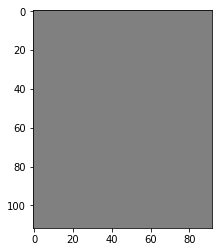

128.0
in
tensor(1.00000e-05 *
       -7.8321, device='cuda:0')
tensor(1.00000e-05 *
       -7.8321, device='cuda:0')
tensor(1.00000e-05 *
       -7.8321, device='cuda:0')


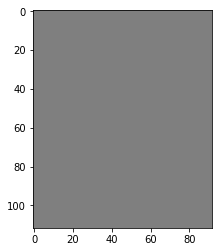

out
tensor(1.00000e-03 *
       -2.4574, device='cuda:0')
tensor(0.4129, device='cuda:0')
tensor(-0.4560, device='cuda:0')


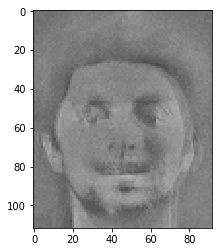

127.19526397515529
0


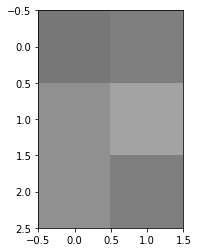

137.0
1
132.82857142857142
in
tensor(1.00000e-02 *
       3.7846, device='cuda:0')
tensor(0.1803, device='cuda:0')
tensor(1.00000e-02 *
       -7.0667, device='cuda:0')


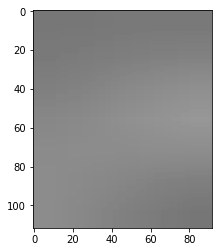

out
tensor(1.00000e-02 *
       3.7839, device='cuda:0')
tensor(0.1803, device='cuda:0')
tensor(1.00000e-02 *
       -7.0688, device='cuda:0')


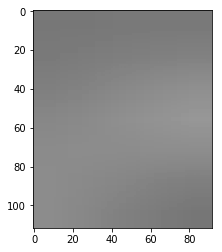

132.1794448757764
0


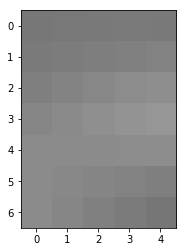

132.14285714285714
1
130.07792207792207
in
tensor(1.00000e-02 *
       1.6229, device='cuda:0')
tensor(1.00000e-02 *
       9.4039, device='cuda:0')
tensor(1.00000e-02 *
       -6.2823, device='cuda:0')


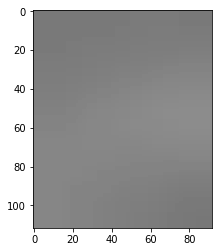

out
tensor(1.00000e-02 *
       -1.3480, device='cuda:0')
tensor(0.3462, device='cuda:0')
tensor(-0.3610, device='cuda:0')


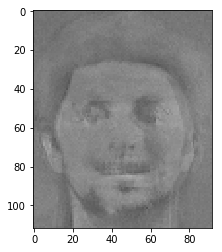

125.79454580745342
0


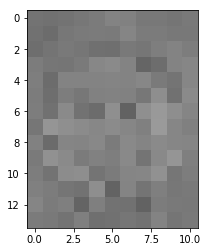

125.01948051948052
1
125.84472049689441
in
tensor(1.00000e-02 *
       -1.6154, device='cuda:0')
tensor(0.1254, device='cuda:0')
tensor(-0.1334, device='cuda:0')


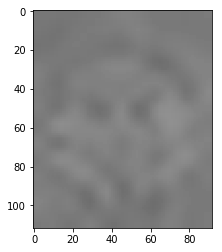

out
tensor(1.00000e-02 *
       -1.6123, device='cuda:0')
tensor(0.1257, device='cuda:0')
tensor(-0.1337, device='cuda:0')


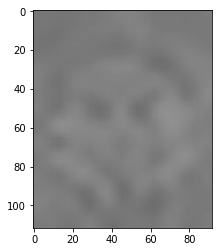

125.54202251552795
0


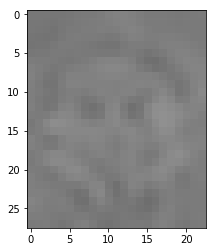

125.58850931677019
1
126.15256211180125
in
tensor(1.00000e-02 *
       -1.3350, device='cuda:0')
tensor(1.00000e-02 *
       7.0510, device='cuda:0')
tensor(1.00000e-02 *
       -8.6353, device='cuda:0')


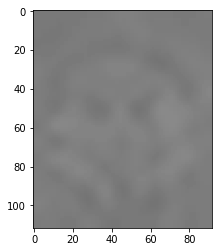

out
tensor(1.00000e-02 *
       -1.1746, device='cuda:0')
tensor(1.00000e-02 *
       9.1093, device='cuda:0')
tensor(-0.1040, device='cuda:0')


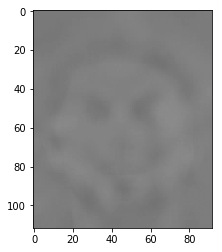

126.00679347826087
0


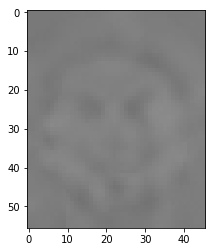

126.0333850931677
1
126.41964285714286
in
tensor(1.00000e-02 *
       -1.2473, device='cuda:0')
tensor(1.00000e-02 *
       4.6981, device='cuda:0')
tensor(1.00000e-02 *
       -7.0667, device='cuda:0')


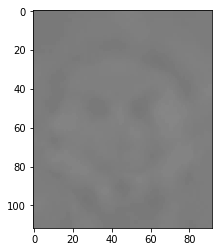

out
tensor(1.00000e-03 *
       -7.7847, device='cuda:0')
tensor(0.1049, device='cuda:0')
tensor(-0.1169, device='cuda:0')


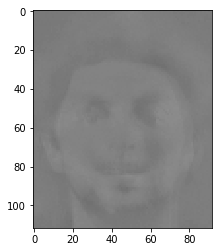

126.51659549689441
0


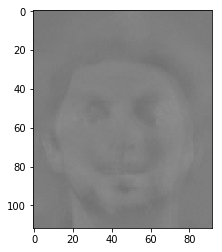

126.51659549689441
1
iteration [0/1]


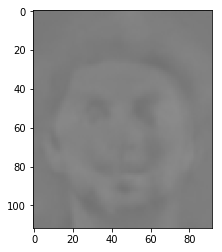

In [154]:
# plt.imshow(np_page,cmap='gray',vmin =-1 , vmax = 1)
# plt.show()
octave_scale = 2 
from PIL import Image, ImageFilter, ImageChops
# page=Image.fromarray(np.uint8(np.random.random((112,92))*255))
page=Image.fromarray(np.uint8(np.ones((112,92))*128))
# print(np.sqrt(np.var(page)))
print(np.mean(page))
plt.imshow(page,cmap='gray',vmin =0 , vmax = 1)
plt.show()

dream=data_extraction(page,net,1,1e-1,2,5,34)
plt.imshow(dream)

In [12]:
def tensorBlur(im , kernel_size):

    channels = 1 
    # Set these to whatever you want for your gaussian filter
#     kernel_size = 15
    sigma = 3

    # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
    x_cord = torch.arange(kernel_size)
    x_grid = x_cord.repeat(kernel_size).view(kernel_size, kernel_size)
    y_grid = x_grid.t()
    xy_grid = torch.stack([x_grid, y_grid], dim=-1)

    mean = (kernel_size - 1)/2.
    variance = sigma**2.

    # Calculate the 2-dimensional gaussian kernel which is
    # the product of two gaussian distributions for two different
    # variables (in this case called x and y)
    gaussian_kernel = (1./(2.*math.pi*variance)) *\
                      torch.exp(
                          -torch.sum((xy_grid - mean)**2., dim=-1) /\
                          (2*variance)
                      )
    # Make sure sum of values in gaussian kernel equals 1.
    gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)

    # Reshape to 2d depthwise convolutional weight
    gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
    gaussian_kernel = gaussian_kernel.repeat(channels, 1, 1, 1)
    gaussian_kernel = gaussian_kernel.to(device)
#     gaussian_kernel = gaussian_kernel.double()
    gaussian_filter = nn.Conv2d(in_channels=channels, out_channels=channels,
                                kernel_size=kernel_size, groups=channels, bias=False, padding=(kernel_size-1)/2)

    gaussian_filter.weight.data = gaussian_kernel
    gaussian_filter.weight.requires_grad = False
    imOut = gaussian_filter((im).unsqueeze(0).unsqueeze(0).to(device))
    return imOut.squeeze()

def tensorSharpen(im , kernel_size):

    channels = 1 
    # Set these to whatever you want for your gaussian filter
    sigma = 3

    # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
    x_cord = torch.arange(kernel_size)
    x_grid = x_cord.repeat(kernel_size).view(kernel_size, kernel_size)
    y_grid = x_grid.t()
    xy_grid = torch.stack([x_grid, y_grid], dim=-1)

    mean = (kernel_size - 1)/2.
    variance = sigma**2.

    # Calculate the 2-dimensional gaussian kernel which is
    # the product of two gaussian distributions for two different
    # variables (in this case called x and y)
    gaussian_kernel = (1./(2.*math.pi*variance)) *\
                      torch.exp(
                          -torch.sum((xy_grid - mean)**2., dim=-1) /\
                          (2*variance)
                      )
    # Make sure sum of values in gaussian kernel equals 1.
    gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)

    # Reshape to 2d depthwise convolutional weight
    gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
    gaussian_kernel = gaussian_kernel.repeat(channels, 1, 1, 1)
    gaussian_kernel = gaussian_kernel.to(device)
#     gaussian_kernel = gaussian_kernel.double()
    gaussian_filter = nn.Conv2d(in_channels=channels, out_channels=channels,
                                kernel_size=kernel_size, groups=channels, bias=False, padding=(kernel_size-1)/2)

    gaussian_filter.weight.data = gaussian_kernel
    gaussian_filter.weight.requires_grad = False
    imOut = gaussian_filter((im).unsqueeze(0).unsqueeze(0).to(device))
    return im-imOut.squeeze()
# def tensor_resize(im, scale):
    

In [25]:
def deep_dream_vgg(image, net, iterations, lr, octave_scale, num_octaves,category):
    net.eval()
    category = Variable(torch.cuda.LongTensor([category]))
    if num_octaves>0:
#         image1 = image.filter(ImageFilter.GaussianBlur(1))
        image1 = tensorBlur(image, 3)
        if(image1.size[0]/octave_scale < 1 or image1.size[1]/octave_scale<1):
            size = image1.size
        else:
            size = (int(image1.size[0]/octave_scale), int(image1.size[1]/octave_scale))

        image1 = image1.resize(size,Image.ANTIALIAS)
        image1 = deep_dream_vgg(image1, net, iterations, lr, octave_scale, num_octaves-1,category)
        size = (image.size[0], image.size[1])
        
        image1 = image1.resize(size,Image.ANTIALIAS)

        image = ImageChops.blend(image, image1, 0.6)
#     print("-------------- Recursive level: ", num_octaves, '--------------')
    img_result = dd_helper(image, net, iterations, lr,category)
    img_result = img_result.resize(image.size)
#     plt.imshow(img_result)
    return img_result

dream_deep=deep_dream_vgg(torch.Tensor((np_page)),net,100,1e-1,34)

plt.imshow(dream_deep.squeeze().cpu().detach().numpy(),cmap='gray')

In [30]:
print(np.sinc(0))
print(9/16)
print(np.sum([0, -0.032, 0, 0.284, 0.496, 0.284, 0, -0.032, 0]))

1.0
0.5625
1.0


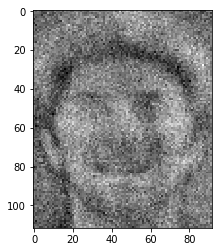

0.9070890214822752


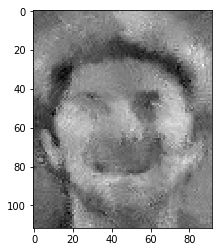

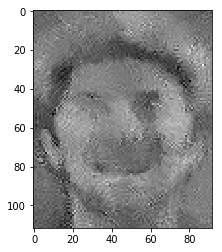

In [21]:
plt.imshow(dream_ga.squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()
dream = dream_ga.squeeze().cpu().detach().numpy()

patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=False)

sigma_est = np.mean(estimate_sigma(dream, multichannel=False))
print(sigma_est)
denoise_fast = denoise_nl_means(dream, h=0.75 * sigma_est, fast_mode=True,
                                **patch_kw)

plt.imshow(denoise_fast, cmap = 'gray')
plt.show()

from scipy import ndimage, misc

kernel = np.array([0, -1/4, 0, -1/4, 2, -1/4, 0, -1/4, 0]).reshape((3, 3))

# here we do the convolution with the kernel
imgsharp = ndimage.filters.convolve(denoise_fast, kernel, mode='nearest')
# then we clip (0 to 255) and convert to unsigned int
# imgsharp = np.clip(imgsharp, 0, 255).astype(np.uint8)
plt.imshow(imgsharp, cmap = 'gray')
plt.show()


In [ ]:
im0 = np.clip((dream_ga.squeeze().cpu().detach().numpy()*.5+.5), 0, 1)*255
plt.imshow(im0,cmap = 'gray')
# dream_ga.mean()

In [ ]:
import cv2 as cv
dst = cv.fastNlMeansDenoising(dream,None, 10 ,10,7,21)
plt.imshow(dst,cmap = 'gray')

In [ ]:
plt.imshow(dream_ga2.squeeze().cpu().detach().numpy(),cmap = 'gray')
print(net(dream_ga2).sum())

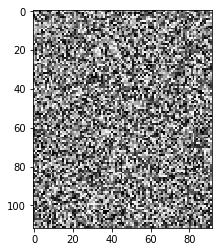

In [70]:
from PIL import Image, ImageFilter, ImageChops
page=Image.fromarray(np.uint8(np.random.random((112,92))*255))

plt.imshow(page)


tensor([ 16])
tensor(-0.9451)
tensor(0.6235)
torch.Size([1, 1, 112, 92])


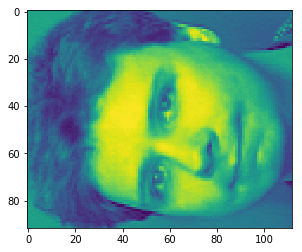

In [391]:
imgs,labels = iter(sampleloader).next()
imshow((imgs.squeeze())) 
print(labels)
print(imgs.min())
print(imgs.max())
print(imgs.size())

9.315478151938894e-05
0.9997980736097306


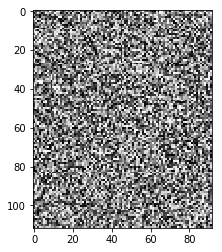

In [110]:
np_page=np.random.random((112,92))
plt.imshow(np_page,cmap='gray')
plt.show

print(np_page.min())
print(np_page.max())

# # Create gaussian kernels
# kernel = Variable(torch.FloatTensor([[[0.006, 0.061, 0.242, 0.383, 0.242, 0.061, 0.006]]]))
# # Create input
# x = Variable(torch.randn(1, 1, 100))
# # Apply smoothing
# x_smooth = F.conv1d(x, kernel)

In [189]:
def tensorBlur(im , kernel_size):

    channels = 1 
    # Set these to whatever you want for your gaussian filter
#     kernel_size = 15
    sigma = 3

    # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
    x_cord = torch.arange(kernel_size)
    x_grid = x_cord.repeat(kernel_size).view(kernel_size, kernel_size)
    y_grid = x_grid.t()
    xy_grid = torch.stack([x_grid, y_grid], dim=-1)

    mean = (kernel_size - 1)/2.
    variance = sigma**2.

    # Calculate the 2-dimensional gaussian kernel which is
    # the product of two gaussian distributions for two different
    # variables (in this case called x and y)
    gaussian_kernel = (1./(2.*math.pi*variance)) *\
                      torch.exp(
                          -torch.sum((xy_grid - mean)**2., dim=-1) /\
                          (2*variance)
                      )
    # Make sure sum of values in gaussian kernel equals 1.
    gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)

    # Reshape to 2d depthwise convolutional weight
    gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
    gaussian_kernel = gaussian_kernel.repeat(channels, 1, 1, 1)
    gaussian_kernel = gaussian_kernel.to(device)
#     gaussian_kernel = gaussian_kernel.double()
    gaussian_filter = nn.Conv2d(in_channels=channels, out_channels=channels,
                                kernel_size=kernel_size, groups=channels, bias=False, padding=(kernel_size-1)/2)

    gaussian_filter.weight.data = gaussian_kernel
    gaussian_filter.weight.requires_grad = False
    imOut = gaussian_filter(torch.tensor(im).unsqueeze(0).unsqueeze(0).to(device))
    return imOut.squeeze()

def tensorSharpen(im , kernel_size):

    channels = 1 
    # Set these to whatever you want for your gaussian filter
    sigma = 3

    # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
    x_cord = torch.arange(kernel_size)
    x_grid = x_cord.repeat(kernel_size).view(kernel_size, kernel_size)
    y_grid = x_grid.t()
    xy_grid = torch.stack([x_grid, y_grid], dim=-1)

    mean = (kernel_size - 1)/2.
    variance = sigma**2.

    # Calculate the 2-dimensional gaussian kernel which is
    # the product of two gaussian distributions for two different
    # variables (in this case called x and y)
    gaussian_kernel = (1./(2.*math.pi*variance)) *\
                      torch.exp(
                          -torch.sum((xy_grid - mean)**2., dim=-1) /\
                          (2*variance)
                      )
    # Make sure sum of values in gaussian kernel equals 1.
    gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)

    # Reshape to 2d depthwise convolutional weight
    gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
    gaussian_kernel = gaussian_kernel.repeat(channels, 1, 1, 1)
    gaussian_kernel = gaussian_kernel.to(device)
#     gaussian_kernel = gaussian_kernel.double()
    gaussian_filter = nn.Conv2d(in_channels=channels, out_channels=channels,
                                kernel_size=kernel_size, groups=channels, bias=False, padding=(kernel_size-1)/2)

    gaussian_filter.weight.data = gaussian_kernel
    gaussian_filter.weight.requires_grad = False
    imOut = gaussian_filter(torch.tensor(im).unsqueeze(0).unsqueeze(0).to(device))
    return im-imOut.squeeze()

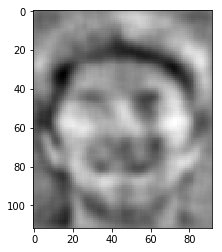

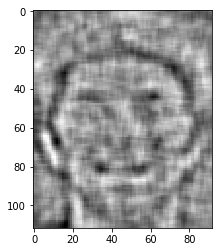

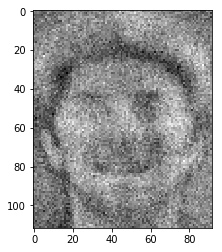

torch.Size([112, 92])


In [196]:
im0 = tensorBlur(dream_ga.squeeze().cpu().detach().numpy(),7)
plt.imshow(im0, cmap = 'gray')
plt.show()

im00 = tensorSharpen(im0.squeeze().cpu().detach().numpy(),7)
plt.imshow(im00, cmap = 'gray')
plt.show()

plt.imshow(dream_ga.squeeze().cpu().detach().numpy(),cmap = 'gray')
plt.show()
# np_page_blur = gaussian_filter(torch.tensor(np_page).unsqueeze(0).unsqueeze(0).to(device))
# print(np_page_blur.size())
# plt.imshow(np_page_blur.squeeze())
print(im0.size())

In [154]:
torch.tensor(np_page).unsqueeze(0).to(device).size()

torch.Size([1, 112, 92])

In [147]:
gaussian_kernel.size()


torch.Size([1, 1, 15, 15])

In [188]:
gk = torch.tensor(np.array([0, -1/4, 0, -1/4, 2, -1/4, 0, -1/4, 0]).reshape((3, 3)))
gk

tensor([[ 0.0000, -0.2500,  0.0000],
        [-0.2500,  2.0000, -0.2500],
        [ 0.0000, -0.2500,  0.0000]], dtype=torch.float64)